In [3]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [4]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [5]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

In [6]:
# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [5]:
train.head()

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

In [6]:
predict.head(3)

,module_name,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_p

In [7]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [7]:
# 모듈 이름의 상위 집계단위를 나타내는 module_name_eq 범주형 변수를 생성하는 함수입니다.
def gen_cate_feats(df):
    df['module_name_eq'] = df['module_name'].apply(lambda x : x.split('_')[0])
    return df 

# 3.4 전체 공정 소요시간에 따른 타깃 변수의 변화

전체 및 개별 공정 소요시간 변수를 생성하는 함수를 작성합니다.

전체 공정 소요시간은 마지막 공정 완료시간 20_end_time 과 첫번째 공정 완료시간 04_end_time 의 차이(초)를 계산한 값입니다.

In [8]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    
    # 개별 스텝간 공정 소요시간(초) 변수를 생성합니다. 
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

# 4. 데이터 전처리

In [9]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()
del train

In [10]:
# -----------------------------------
# 3 장 EDA 분석에 필요한 변수를 선언합니다.
# -----------------------------------

# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
# df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [11]:
# 모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수를 생성합니다(3.3절)
df_train = gen_cate_feats(df_train)
df_predict = gen_cate_feats(df_predict)
df_train.filter(regex='module_name_eq').head(2)

,module_name_eq
0,EQ10
1,EQ10


In [12]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


# Category 변수 처리

In [13]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
eq2idx = {}
for i, eq in enumerate(df_train['module_name_eq'].unique()):
    eq2idx[eq] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)
# eq cat 화
col2cat(df_train, 'module_name_eq', eq2idx)
col2cat(df_predict, 'module_name_eq', eq2idx)
    
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_train.columns[df_train.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

# 이상치 처리

In [19]:
df_train.loc[df_train['04_fr_para35']!=0,:]

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

In [20]:
df_train[df_train.module_name==29]

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_epd_para4,04_epd_para40,04_epd_para63,04_epd_para80,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para1,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para14,04_power_para49,04_power_para57,04_power_para68,04_power_para76,04_power_para82,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para24,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para5,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_epd_para80,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para1,06_he_para22,06_he_para88,06_he_para95,06_hv_para3,06_hv_para45,06_hv_para47,06_hv_para56,06_position_para72,06_power_para14,06_power_para49,06_power_para57,06_power_para68,06_power_para76,06_power_para82,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para24,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para5,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_epd_para4,12_epd_para40,12_epd_para63,12_epd_para80,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para1,12_he_para22,12_he_para88,12_he_para95,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para49,12_power_para57,12_power_para68,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para54,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para

outlier는 그대로 둔다. 어차피 PCA에서 처리될것임.

In [14]:
# 기존 센서 변수(665개)와 생성 변수 중 수치형 변수(102개) 컬럼을 정의합니다. 
col_numerical = col_sensor + df_train.filter(regex='^gen_').columns.tolist()

In [22]:
for col in col_numerical:
    # 열마다 학습 데이터의 1%, 99% 지점을 확인합니다.
    p01 = df_train[col].quantile(0.01) 
    p99 = df_train[col].quantile(0.99) 

    # 1%점 이하의 값은 1%점으로, 99%점 이상의 값은 99%점으로 클리핑합니다. 
    df_train[col] = df_train[col].clip(p01, p99)
    df_predict[col] = df_predict[col].clip(p01, p99)

# 분산이 0인 변수 제거

분산 기준 설정(Variance Thresholding)은 가장 기본적인 특성 선택 방법 중 하나입니다.

분산이 0 인 특징은 정보가 없으므로 해당 특징을 삭제합니다.

In [15]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택할 수 있습니다.
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출합니다.  
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 65 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_he_para1', '04_power_para14', '04_power_para49', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_he_para1', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_para82', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_epd_para40', '12_epd_para63', '12_epd_para80', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para68', '12_temp_para54', '13_epd_para4', '13_epd_para40', '13_epd_para63', '13_epd_para80', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para68', '13_temp_para54', '17_epd_para4', '17_epd_para40', '17_epd_para63', '17_epd_para80', '17_he_para1', '17_he_para95', '17_power_para49', '17_power_para68', '17_temp_para54', '18_epd_para4', '18_epd_para40', '18_epd_para63', '18_epd_para80', '18_he_para1', '18_he_para95', '18_power_para49', '

In [16]:
df_train.drop(cols_var_drop,axis=1, inplace=True)
df_predict.drop(cols_var_drop,axis=1, inplace=True)

# StandardScaling 적용

In [17]:
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_train.columns[df_train.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

In [18]:
means = []
stds = []
m = df_train.loc[:,num_features].mean()
means.append(m)
s = df_train.loc[:,num_features].std()
stds.append(s)
df_train.loc[:,num_features] = (df_train.loc[:,num_features]-m)/s

In [19]:
df_predict.loc[:,num_features] = (df_predict.loc[:,num_features] - means[0])/stds[0]

In [20]:
df_train.head()

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para84,04_esc_para94,04_fr_para28,04_fr_para35,04_fr_para61,04_fr_para69,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_he_para95,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para35,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_he_para95,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para84,13_esc_para94,13_fr_para28,13_fr_para35,13_fr_para61,13_fr_para69,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46

# PCA를 이용한 차원축소

In [62]:
df_train.head(3)

,module_name,key_val,end_dt_tm,y,04_efem_para2,04_efem_para25,04_efem_para78,04_esc_para94,04_fr_para28,04_fr_para61,04_gas_para10,04_gas_para13,04_gas_para15,04_gas_para19,04_gas_para21,04_gas_para26,04_gas_para27,04_gas_para33,04_gas_para36,04_gas_para39,04_gas_para46,04_gas_para48,04_gas_para50,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para70,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para57,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para58,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_temp_para93,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para41,04_time_para42,04_time_para43,04_time_para44,04_time_para62,04_time_para64,04_time_para67,04_time_para7,04_time_para75,04_time_para77,04_time_para8,04_time_para81,04_time_para83,04_time_para89,04_time_para9,04_time_para90,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_esc_para84,06_esc_para94,06_fr_para28,06_fr_para61,06_fr_para69,06_gas_para10,06_gas_para13,06_gas_para15,06_gas_para19,06_gas_para21,06_gas_para26,06_gas_para27,06_gas_para33,06_gas_para36,06_gas_para39,06_gas_para46,06_gas_para48,06_gas_para50,06_gas_para51,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para70,06_gas_para71,06_gas_para73,06_gas_para74,06_gas_para85,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para58,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_temp_para93,06_time_para16,06_time_para29,06_time_para30,06_time_para34,06_time_para37,06_time_para41,06_time_para42,06_time_para43,06_time_para44,06_time_para62,06_time_para64,06_time_para67,06_time_para7,06_time_para75,06_time_para77,06_time_para8,06_time_para81,06_time_para83,06_time_para89,06_time_para9,06_time_para90,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_esc_para84,12_esc_para94,12_fr_para28,12_fr_para35,12_fr_para61,12_fr_para69,12_gas_para10,12_gas_para13,12_gas_para15,12_gas_para19,12_gas_para21,12_gas_para26,12_gas_para27,12_gas_para33,12_gas_para36,12_gas_para39,12_gas_para46,12_gas_para48,12_gas_para50,12_gas_para51,12_gas_para52,12_gas_para59,12_gas_para6,12_gas_para70,12_gas_para71,12_gas_para73,12_gas_para74,12_gas_para85,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para57,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para17,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_temp_para93,12_time_para16,12_time_para29,12_time_para30,12_time_para34,12_time_para37,12_time_para41,12_time_para42,12_time_para43,12_time_para44,12_time_para5,12_time_para62,12_time_para64,12_time_para67,12_time_para7,12_time_para75,12_time_para77,12_time_para8,12_time_para81,12_time_para83,12_time_para89,12_time_para9,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_esc_para94,13_fr_para35,13_fr_para61,13_gas_para10,13_gas_para13,13_gas_para15,13_gas_para19,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para33,13_gas_para36,13_gas_para39,13_gas_para46,13_gas_para48,13_gas_para50,13_gas_para51,13_gas_para52,13_gas_para59,13_gas_para6,13_gas_para70,13_gas_para71,13_gas_

In [21]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [22]:
step_lst = ['04','06','12','13','17','18','20']

In [23]:
def pca_pre(datas,pred_datas, cols, n, step): 
    pca = decomposition.PCA(n_components = n) 
    pca_array = pca.fit_transform(datas[cols]) 
    pca_array_pred = pca.transform(pred_datas[cols]) 
    pca_df_train = pd.DataFrame(data = pca_array, columns = ['{0}_pca{1}'.format(step, num) for num in range(n)]) 
    pca_df_pred = pd.DataFrame(data = pca_array_pred, columns = ['{0}_pca{1}'.format(step, num) for num in range(n)]) 
    return pca_df_train, pca_df_pred

In [24]:
for i,col in enumerate(step_lst): 
    cols = df_final.filter(regex='^'+col).columns.tolist() 
    cols = list(set(cols)) 
    cols.remove(col+'_end_time') 
    n_cols = len(cols) 
    pca = decomposition.PCA(n_components = n_cols-1) 
    pca_array = pca.fit_transform(df_final[cols])
    result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,\
         '기여율':pca.explained_variance_ratio_},\
        index=np.array([f"pca{num+1}" for num in range(n_cols-1)]))
    result['누적기여율'] = result['기여율'].cumsum()
    if len(result.loc[result['누적기여율']>=0.8,:].index) >=1:
        n = result.loc[result['누적기여율']>=0.8,:].index[0][-2]
        try:
            n = int(result.loc[result['누적기여율']>=0.8,:].index[0][-2:])
            df, df_p = pca_pre(df_final, df_predict_final, cols, n, col)
            df_final = pd.concat([df_final, df],axis=1)
            df_predict_final = pd.concat([df_predict_final, df_p],axis=1)
            df_final.drop(cols, axis=1, inplace=True)
            df_predict_final.drop(cols, axis=1, inplace=True)
        except ValueError:
            n = int(result.loc[result['누적기여율']>=0.8,:].index[0][-1])
            df, df_p = pca_pre(df_final, df_predict_final, cols, n, col)
            df_final = pd.concat([df_final, df],axis=1)
            df_predict_final = pd.concat([df_predict_final, df_p],axis=1)
            df_final.drop(cols, axis=1, inplace=True)
            df_predict_final.drop(cols, axis=1, inplace=True)
    else:
        print(cols)
        # 얘네는 그럼 줄일 수 없다? 혹은 drop이다.

In [29]:
df_final.head()

,module_name,key_val,end_dt_tm,y,04_end_time,06_end_time,12_end_time,13_end_time,17_end_time,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820,04_pca0,04_pca1,04_pca2,04_pca3,04_pca4,04_pca5,04_pca6,04_pca7,04_pca8,04_pca9,04_pca10,04_pca11,04_pca12,04_pca13,04_pca14,04_pca15,04_pca16,04_pca17,04_pca18,04_pca19,04_pca20,04_pca21,04_pca22,04_pca23,04_pca24,06_pca0,06_pca1,06_pca2,06_pca3,06_pca4,06_pca5,06_pca6,06_pca7,06_pca8,06_pca9,06_pca10,06_pca11,06_pca12,06_pca13,06_pca14,06_pca15,06_pca16,06_pca17,06_pca18,06_pca19,06_pca20,06_pca21,06_pca22,06_pca23,12_pca0,12_pca1,12_pca2,12_pca3,12_pca4,12_pca5,12_pca6,12_pca7,12_pca8,12_pca9,12_pca10,12_pca11,12_pca12,12_pca13,12_pca14,12_pca15,12_pca16,12_pca17,12_pca18,12_pca19,12_pca20,12_pca21,12_pca22,12_pca23,13_pca0,13_pca1,13_pca2,13_pca3,13_pca4,13_pca5,13_pca6,13_pca7,13_pca8,13_pca9,13_pca10,13_pca11,13_pca12,13_pca13,13_pca14,13_pca15,13_pca16,13_pca17,13_pca18,13_pca19,13_pca20,13_pca21,13_pca22,13_pca23,13_pca24,13_pca25,17_pca0,17_pca1,17_pca2,17_pca3,17_pca4,17_pca5,17_pca6,17_pca7,17_pca8,17_pca9,17_pca10,17_pca11,17_pca12,17_pca13,17_pca14,17_pca15,17_pca16,17_pca17,17_pca18,17_pca19,17_pca20,17_pca21,17_pca22,17_pca23,18_pca0,18_pca1,18_pca2,18_pca3,18_pca4,18_pca5,18_pca6,18_pca7,18_pca8,18_pca9,18_pca10,18_pca11,18_pca12,18_pca13,18_pca14,18_pca15,18_pca16,18_pca17,18_pca18,18_pca19,18_pca20,18_pca21,18_pca22,18_pca23,18_pca24,18_pca25,20_pca0,20_pca1,20_pca2,20_pca3,20_pca4,20_pca5,20_pca6,20_pca7,20_pca8,20_pca9,20_pca10,20_pca11,20_pca12,20_pca13,20_pca14,20_pca15,20_pca16,20_pca17,20_pca18,20_pca19,20_pca20,20_pca21,20_pca22,20_pca23,20_pca24
0,0,LOT5_21,2021-10-03 07:10:22,1260.08920,2021-10-02 22:14:27,2021-10-02 22:16:53,2021-10-02 22:30:59,2021-10-02 22:31:15,2021-10-02 22:39:12,2021-10-02 22:39:28,2021-10-02 22:46:19,0,0.848945,0.707691,0.855510,0.033653,1.080150,-0.049079,0.438803,-0.921318,-2.527230,0.597488,-0.056396,0.499919,-2.878220,0.288933,-0.116659,1.288481,-0.760559,0.657269,0.910430,0.496886,-0.814338,-0.486306,-0.280473,1.134335,-0.430004,1.988910,-0.408611,0.130763,-0.839524,-0.829949,-0.066599,0.016573,-0.755769,-2.520702,0.811938,-0.562742,1.538031,1.047977,1.178424,-2.098642,-0.818859,1.073040,-0.687021,1.084486,-0.469733,1.021608,0.772006,0.353696,-0.747047,-0.315600,-0.192993,0.066198,1.198139,-0.544875,-0.485792,-0.645401,-0.814316,-2.590377,-1.077823,-0.389164,-0.731161,1.642757,-3.707715,1.470497,-1.363051,0.848239,-0.920970,-0.006465,1.393115,0.771284,-0.301596,0.250049,0.087234,0.405916,1.254061,0.335837,2.274380,-1.158168,-0.465277,1.574426,-1.259373,-2.632567,-1.209485,-1.390193,-0.954302,0.593841,-0.173777,-4.661944,3.145979,-3.577867,-0.441619,0.028660,-2.308371,-5.059220,11.851444,1.430556,-6.982128,5.692597,8.633850,9.144078,4.446338,-2.154525,-0.185928,6.199553,-3.281684,-0.724885,-0.364498,-2.685350,-1.255077,-0.625174,-0.890668,1.003543,-0.869019,-1.165256,0.789412,-1.119887,-1.484929,-1.358647,1.206602,-0.721825,-0.282886,0.356885,1.727524,-0.024944,0.183501,-1.355737,0.260778,-0.534541,2.082717,-0.038557,-0.255338,-2.696099,-0.795192,-0.649015,-1.242730,0.739712,-0.275752,-1.993585,-1.147855,0.144390,-1.549830,0.085556,1.724010,1.628305,-0.633337,-1.047319,-0.439414,-1.906476,0.831763,-0.070526,0.012934,0.324430,-0.249481,-0.487668,-1.650608,-0.466376,0.857660,-2.509978,-0.092373,-1.517653,-0.155993,3.111695,0.318369,-0.689476,0.288153,1.043007,-2.140540,1.047313,-0.680423,-0.811425,-0.331062,0.472529,1.995128,0.281065,1.112848,-1.366108,-0.532479,0.435981,-1.277512,-0.251504,-1.387853
1,0,LOT126_21,2021-10-04 23:34:27,1253.30152,2021-10-04 11:09:20,2021-10-04 11:11:45,2021-10-04 11:25:52,2021-10-04 11:26:08,2021-10-04 11:34:04,2021-10-04 11:34:20,2021-10-04 11:41:11,0,0.805177,0.584955,0.922311,0.033653,-0.742976,-0.049079,0.438803,-1.119866,-1.839392,0.774415,-0.203995,-0.929259,-3.733978,1.258155,-0.092142,0.852512,-0.9407

In [30]:
df_predict_final.head()

,module_name,key_val,04_end_time,06_end_time,12_end_time,13_end_time,17_end_time,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820,04_pca0,04_pca1,04_pca2,04_pca3,04_pca4,04_pca5,04_pca6,04_pca7,04_pca8,04_pca9,04_pca10,04_pca11,04_pca12,04_pca13,04_pca14,04_pca15,04_pca16,04_pca17,04_pca18,04_pca19,04_pca20,04_pca21,04_pca22,04_pca23,04_pca24,06_pca0,06_pca1,06_pca2,06_pca3,06_pca4,06_pca5,06_pca6,06_pca7,06_pca8,06_pca9,06_pca10,06_pca11,06_pca12,06_pca13,06_pca14,06_pca15,06_pca16,06_pca17,06_pca18,06_pca19,06_pca20,06_pca21,06_pca22,06_pca23,12_pca0,12_pca1,12_pca2,12_pca3,12_pca4,12_pca5,12_pca6,12_pca7,12_pca8,12_pca9,12_pca10,12_pca11,12_pca12,12_pca13,12_pca14,12_pca15,12_pca16,12_pca17,12_pca18,12_pca19,12_pca20,12_pca21,12_pca22,12_pca23,13_pca0,13_pca1,13_pca2,13_pca3,13_pca4,13_pca5,13_pca6,13_pca7,13_pca8,13_pca9,13_pca10,13_pca11,13_pca12,13_pca13,13_pca14,13_pca15,13_pca16,13_pca17,13_pca18,13_pca19,13_pca20,13_pca21,13_pca22,13_pca23,13_pca24,13_pca25,17_pca0,17_pca1,17_pca2,17_pca3,17_pca4,17_pca5,17_pca6,17_pca7,17_pca8,17_pca9,17_pca10,17_pca11,17_pca12,17_pca13,17_pca14,17_pca15,17_pca16,17_pca17,17_pca18,17_pca19,17_pca20,17_pca21,17_pca22,17_pca23,18_pca0,18_pca1,18_pca2,18_pca3,18_pca4,18_pca5,18_pca6,18_pca7,18_pca8,18_pca9,18_pca10,18_pca11,18_pca12,18_pca13,18_pca14,18_pca15,18_pca16,18_pca17,18_pca18,18_pca19,18_pca20,18_pca21,18_pca22,18_pca23,18_pca24,18_pca25,20_pca0,20_pca1,20_pca2,20_pca3,20_pca4,20_pca5,20_pca6,20_pca7,20_pca8,20_pca9,20_pca10,20_pca11,20_pca12,20_pca13,20_pca14,20_pca15,20_pca16,20_pca17,20_pca18,20_pca19,20_pca20,20_pca21,20_pca22,20_pca23,20_pca24
0,0,LOT380_17,2021-10-28 08:15:36,2021-10-28 08:17:39,2021-10-28 08:30:54,2021-10-28 08:31:10,2021-10-28 08:39:06,2021-10-28 08:39:22,2021-10-28 08:46:13,0,-2.433725,-2.115238,-2.551333,0.033653,-0.742976,-0.049079,0.438803,3.390040,-1.079600,-4.822832,2.329519,-1.264704,-0.587716,0.398980,0.459381,0.681910,0.978788,0.659855,1.227486,0.250577,0.210304,0.576231,0.406749,-0.395206,0.859116,-0.096901,-0.421110,-0.615014,-0.707308,-0.947631,-0.395143,-0.024687,3.129397,-0.980194,-4.611446,2.519584,-0.173297,1.240304,0.262673,-1.002478,0.939899,0.370080,-1.486628,0.196353,-0.544278,-0.097003,-0.812152,0.140571,-1.176662,-0.605308,-0.419802,0.676097,-0.327211,-0.406664,0.030376,0.158517,1.412953,-3.082093,1.688594,-1.488331,2.602628,0.265320,-2.349014,0.853445,0.914590,0.560932,0.957033,-0.328064,0.297612,1.154176,0.271157,0.071644,-1.180196,-1.103068,-0.179803,-0.368812,1.234384,0.279048,-0.208469,-1.173510,0.976573,-3.431004,2.170070,-0.900976,2.807596,-0.788998,1.296102,-2.528470,0.440574,-2.065115,1.420871,1.640169,-1.042355,0.085833,1.051265,-0.564698,-0.661329,0.885282,-0.283851,-0.668523,0.260414,-0.296697,-0.367249,-0.253161,0.347894,-0.301843,1.792878,-2.941563,1.748225,-1.558138,2.612026,0.293690,-0.117831,-2.271704,0.171585,-0.620793,0.167843,-1.216913,0.576370,-1.366563,-0.710664,-0.212957,0.083108,0.449114,-0.601132,0.222560,1.007458,-0.149648,2.454618,0.026260,2.119704,-2.696399,1.886627,-1.689068,2.297647,-0.239373,-2.026620,-2.587727,2.569322,-0.537501,-0.982879,2.455760,-0.796427,0.590062,-0.582538,-2.167636,-1.374732,1.161534,0.894618,-0.680170,-0.317532,-0.201903,0.091409,-0.615339,-0.794233,0.563960,2.674823,-0.946302,1.760400,0.084165,2.098818,1.550620,0.397408,-2.612719,0.787897,-0.027701,-0.467175,0.597860,-0.635391,0.191328,0.071520,-0.490687,1.577084,0.663718,1.601230,-1.490975,0.614850,0.795205,-1.020879,-0.629275,-0.734147
1,0,LOT122_18,2021-10-29 11:49:10,2021-10-29 11:51:12,2021-10-29 12:04:28,2021-10-29 12:04:44,2021-10-29 12:12:41,2021-10-29 12:12:57,2021-10-29 12:19:48,0,-2.389956,-2.237974,-2.484532,0.033653,1.080150,-0.049079,0.438803,3.340564,-0.757224,-4.872713,2.572250,-1.042612,-0.890078,0.797342,0.072532,0.917775,0.703280,0.497591,1.027841,0.367895,-0.567835,0.469793,-0.158215,0.261643,0.902134,-0.059920,

In [25]:
# num feature 정의(y 제외하고 해야함.)
cat_features = ['module_name','module_name_eq']
num_features = list(df_final.columns[df_final.dtypes==float])
num_features.remove('y')

COLS = cat_features+num_features

# 4.6 변수 선택 - 나중에
변수 선택은 주어진 데이터의 변수 중에서 모델링의 가장 적절한 변수만 선택하는 과정입니다.

변수 선택 방법은 필터 방법(Filter method), 래퍼 방법(Wrapper method), 임베디드 방법(Embeded method)이 있습니다.

필터 방법 : 통계량(ex. 상관계수, 카이제곱, 상호정보량)을 구하여 가장 뛰어난 특성을 선택하는 기법 (ex. SelectKBest)
래퍼 방법 : 시행착오를 통해 가장 높은 품질의 예측을 만드는 특성의 부분조합을 찾는 기법 (ex. RFE, RFECV)
임베디드 방법 : 결정트리 모델로부터 생성된 특징 중요도를 이용하여 특성을 선택하는 기법 (ex. SelectFromModel)
다음은 필터 방법중 상호정보량을 사용하여 중요 특성을 추출하는 예제코드입니다.

참가자들은 자유롭게 분석하며, 변수 선택 중 한가지 방법으로 참고할 수 있습니다.

# 모델링

In [27]:
from catboost import CatBoostRegressor
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

In [2]:
with open('df_final.p', 'rb') as f:
    df_final = pickle.load(f)
    
with open('df_predict_final.p', 'rb') as f:
    df_predict_final = pickle.load(f)
    
with open('COLS.p', 'rb') as f:
    COLS = pickle.load(f)

In [28]:
X = df_final[COLS]
X_one_hot = pd.get_dummies(X)
y = df_final['y'].values
for_pycaret = X_one_hot.copy()
for_pycaret['y'] = y
X_predict = df_predict_final[COLS]
X_predict_one_hot = pd.get_dummies(X_predict)

In [26]:
with open('df_final.p', 'wb') as f:
    pickle.dump(df_final, f)
    
with open('df_predict_final.p', 'wb') as f:
    pickle.dump(df_predict_final, f)
    
with open('COLS.p', 'wb') as f:
    pickle.dump(COLS, f)

In [29]:
del df_train
del df_predict

# XGB REGRESSOR

In [203]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [208]:
def objective(trial):
    params_xgb = {
        'objective':'reg:squaredlogerror',
        'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1000.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'random_state': trial.suggest_categorical('random_state', [0]),
        'random_state':0,
        'eval_metric':'rmsle'
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(X_one_hot, np.log1p(y), test_size=0.2, random_state=0)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, xgb_pred))
    
    return rmsle_val

In [209]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-05 16:48:58,906] A new study created in memory with name: xgb_parameter_opt
[I 2022-07-05 16:48:59,879] Trial 0 finished with value: 0.0062980724841724105 and parameters: {'booster': 'gblinear', 'reg_lambda': 598.6584841970366, 'learning_rate': 0.018410729205738687, 'n_estimators': 1644, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.
[I 2022-07-05 16:49:01,544] Trial 1 finished with value: 0.006298612820331265 and parameters: {'booster': 'gblinear', 'reg_lambda': 708.0725777960455, 'learning_rate': 0.01083858126934475, 'n_estimators': 9703, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.
[I 2022-07-05 16:49:11,038] Trial 2 finished with value: 0.006859427286384481 and parameters: {'booster': 'gbtree', 'reg_lambda': 183.4045098534338, 'learning_rate': 0.0328774741399112, 'n_estimators': 5295, 'random_state': 0}. Best is trial 0 with value: 0.0062980724841724105.


KeyboardInterrupt: 

In [39]:
model = xgb.XGBRegressor(**study.best_params)
model.fit(X_XGB, np.log1p(y))

[02:05:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0, feature_fraction=0.4,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0824937112007298,
             max_delta_step=0, max_depth=5, min_child_weight=56, missing=nan,
             monotone_constraints='()', n_estimators=2087, n_jobs=12,
             num_parallel_tree=1, optimizer='dart', random_state=0, reg_alpha=0,
             reg_lambda=0.8366438994666325, scale_pos_weight=1,
             subsample=0.8907860711978364, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [62]:
with open('xgb0.0048.p', 'wb') as f:
    pickle.dump(model, f)

# LGBMRegressor

In [34]:
import lightgbm as lgb

In [37]:
# define function
def objective(trial):
    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'random_state':0
    }
    
    X_lgb = X
    y_lgb = pd.Series(np.log1p(y))
    
    tscv = TimeSeriesSplit(n_splits=47)
    rmse_list = []
    model_name = 'LGBMRegressor'
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_lgb), start=1), desc=f'{model_name} Cross Validations...', total=47):
        X_train, X_test = X_lgb.iloc[train_index], X_lgb.iloc[test_index]
        y_train, y_test = y_lgb.iloc[train_index], y_lgb.iloc[test_index]
        model_lgbm = lgb.LGBMRegressor(**lgbm_param)
        model_lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=35, verbose=100)
        pred = model_lgbm.predict(X_test)
        rmse = RMSE(y_test, pred)
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [38]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-07 01:02:05,162] A new study created in memory with name: lgb_parameter_opt
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 30.26it/s]
[I 2022-07-07 01:02:06,720] Trial 0 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 17, 'colsample_bytree': 0.9655000144869412, 'reg_alpha': 0.7319939418114051, 'reg_lambda': 5.986584841970366, 'max_depth': 5, 'learning_rate': 0.08643731496473929, 'n_estimators': 675, 'min_child_samples': 88, 'subsample': 0.7207805082202461}. Best is trial 0 with value: 0.006368648360278207.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 31.62it/s]
[I 2022-07-07 01:02:08,212] Trial 1 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 152, 'colsample_bytree': 0.3144091460070617, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 8.324426408004218, 'max_depth': 5, 'learning_rate': 0.099094233931479

[100]	valid_0's rmse: 0.005213
[100]	valid_0's rmse: 0.00613638
[100]	valid_0's rmse: 0.00459813
[200]	valid_0's rmse: 0.00443618
[100]	valid_0's rmse: 0.00565264


LGBMRegressor Cross Validations...:  43%|███████████████████▌                          | 20/47 [00:00<00:01, 21.38it/s]

[100]	valid_0's rmse: 0.00415039
[200]	valid_0's rmse: 0.00394014
[300]	valid_0's rmse: 0.00382588
[400]	valid_0's rmse: 0.00372508
[500]	valid_0's rmse: 0.00367932
[600]	valid_0's rmse: 0.00364915
[700]	valid_0's rmse: 0.00362705
[100]	valid_0's rmse: 0.00618776
[200]	valid_0's rmse: 0.00598174


LGBMRegressor Cross Validations...:  55%|█████████████████████████▍                    | 26/47 [00:00<00:00, 22.39it/s]

[100]	valid_0's rmse: 0.00982813


LGBMRegressor Cross Validations...:  62%|████████████████████████████▍                 | 29/47 [00:01<00:00, 22.80it/s]

[100]	valid_0's rmse: 0.00548111
[200]	valid_0's rmse: 0.0051211
[300]	valid_0's rmse: 0.00499059
[400]	valid_0's rmse: 0.0049258
[100]	valid_0's rmse: 0.00537595


LGBMRegressor Cross Validations...:  72%|█████████████████████████████████▎            | 34/47 [00:01<00:00, 15.40it/s]

[100]	valid_0's rmse: 0.00695915
[200]	valid_0's rmse: 0.00666668
[300]	valid_0's rmse: 0.00644427
[400]	valid_0's rmse: 0.00634555


LGBMRegressor Cross Validations...:  83%|██████████████████████████████████████▏       | 39/47 [00:01<00:00, 14.75it/s]

[100]	valid_0's rmse: 0.00393389
[200]	valid_0's rmse: 0.00373366
[300]	valid_0's rmse: 0.0037542


LGBMRegressor Cross Validations...:  94%|███████████████████████████████████████████   | 44/47 [00:02<00:00, 14.58it/s]

[100]	valid_0's rmse: 0.00687917
[200]	valid_0's rmse: 0.00656905


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 19.64it/s]
[I 2022-07-07 01:02:12,075] Trial 3 finished with value: 0.006076017016875954 and parameters: {'num_leaves': 43, 'colsample_bytree': 0.7146901982034297, 'reg_alpha': 0.046450412719997725, 'reg_lambda': 6.075448519014383, 'max_depth': 5, 'learning_rate': 0.041875280562786964, 'n_estimators': 9494, 'min_child_samples': 97, 'subsample': 0.8658781436815228}. Best is trial 3 with value: 0.006076017016875954.
LGBMRegressor Cross Validations...:  11%|█████                                          | 5/47 [00:00<00:00, 42.73it/s]

[100]	valid_0's rmse: 0.00513894


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 33.52it/s]
[I 2022-07-07 01:02:13,482] Trial 4 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 11, 'colsample_bytree': 0.3683704798044687, 'reg_alpha': 0.6842330265121569, 'reg_lambda': 4.4015249373960135, 'max_depth': 4, 'learning_rate': 0.2526366859545224, 'n_estimators': 440, 'min_child_samples': 92, 'subsample': 0.48114598712001183}. Best is trial 3 with value: 0.006076017016875954.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 30.94it/s]
[I 2022-07-07 01:02:15,005] Trial 5 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 113, 'colsample_bytree': 0.5181977532625877, 'reg_alpha': 0.5200680211778108, 'reg_lambda': 5.4671027934327965, 'max_depth': 5, 'learning_rate': 0.4850964676046337, 'n_estimators': 7774, 'min_child_samples': 95, 'subsample': 0.9263791452993542}. B

[100]	valid_0's rmse: 0.00504742


LGBMRegressor Cross Validations...:  70%|████████████████████████████████▎             | 33/47 [00:01<00:00, 22.78it/s]

[100]	valid_0's rmse: 0.00496602


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 23.91it/s]
[I 2022-07-07 01:02:16,975] Trial 6 finished with value: 0.006024343226830653 and parameters: {'num_leaves': 74, 'colsample_bytree': 0.9453119645161818, 'reg_alpha': 0.0884925020519195, 'reg_lambda': 1.959828624191452, 'max_depth': 3, 'learning_rate': 0.16941186207399953, 'n_estimators': 3948, 'min_child_samples': 31, 'subsample': 0.8801162564063505}. Best is trial 6 with value: 0.006024343226830653.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 31.26it/s]
[I 2022-07-07 01:02:18,482] Trial 7 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 15, 'colsample_bytree': 0.49665415678116653, 'reg_alpha': 0.5426960831582485, 'reg_lambda': 1.4092422497476265, 'max_depth': 13, 'learning_rate': 0.046529815403087704, 'n_estimators': 9871, 'min_child_samples': 79, 'subsample': 0.43910097707392065

[100]	valid_0's rmse: 0.00498247


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 25.47it/s]
[I 2022-07-07 01:02:21,893] Trial 9 finished with value: 0.006022683604518445 and parameters: {'num_leaves': 88, 'colsample_bytree': 0.5316286173968544, 'reg_alpha': 0.06355835028602363, 'reg_lambda': 3.109823217156622, 'max_depth': 7, 'learning_rate': 0.3675070273856514, 'n_estimators': 6412, 'min_child_samples': 90, 'subsample': 0.6305504476133645}. Best is trial 9 with value: 0.006022683604518445.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 18.05it/s]
[I 2022-07-07 01:02:24,530] Trial 10 finished with value: 0.006305599830533552 and parameters: {'num_leaves': 776, 'colsample_bytree': 0.7135077979737247, 'reg_alpha': 0.25353172560829995, 'reg_lambda': 3.4685089140662195, 'max_depth': 9, 'learning_rate': 0.4274679417203565, 'n_estimators': 6578, 'min_child_samples': 64, 'subsample': 0.5604030283908563}.

[100]	valid_0's rmse: 0.00593708


LGBMRegressor Cross Validations...:  49%|██████████████████████▌                       | 23/47 [00:00<00:01, 23.54it/s]

[100]	valid_0's rmse: 0.00495211


LGBMRegressor Cross Validations...:  77%|███████████████████████████████████▏          | 36/47 [00:01<00:00, 15.26it/s]

[100]	valid_0's rmse: 0.00420554


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 18.59it/s]
[I 2022-07-07 01:02:27,090] Trial 11 finished with value: 0.005826031897077027 and parameters: {'num_leaves': 186, 'colsample_bytree': 0.8373601441019004, 'reg_alpha': 0.008759148737315897, 'reg_lambda': 2.858543084450991, 'max_depth': 9, 'learning_rate': 0.367741578063687, 'n_estimators': 6234, 'min_child_samples': 46, 'subsample': 0.7807705470234294}. Best is trial 11 with value: 0.005826031897077027.
LGBMRegressor Cross Validations...:  74%|██████████████████████████████████▎           | 35/47 [00:01<00:00, 20.45it/s]

[100]	valid_0's rmse: 0.00645104


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 21.75it/s]
[I 2022-07-07 01:02:29,287] Trial 12 finished with value: 0.006329159523645183 and parameters: {'num_leaves': 347, 'colsample_bytree': 0.8215177938440218, 'reg_alpha': 0.2723508930113727, 'reg_lambda': 3.217671776002649, 'max_depth': 9, 'learning_rate': 0.3636531991892122, 'n_estimators': 6530, 'min_child_samples': 55, 'subsample': 0.7578667958023638}. Best is trial 11 with value: 0.005826031897077027.
LGBMRegressor Cross Validations...:  43%|███████████████████▌                          | 20/47 [00:00<00:01, 19.68it/s]

[100]	valid_0's rmse: 0.00670758
[200]	valid_0's rmse: 0.00670758
[300]	valid_0's rmse: 0.00670758
[400]	valid_0's rmse: 0.00670758
[500]	valid_0's rmse: 0.00670758
[600]	valid_0's rmse: 0.00670758
[700]	valid_0's rmse: 0.00670758
[800]	valid_0's rmse: 0.00670758
[900]	valid_0's rmse: 0.00670758


LGBMRegressor Cross Validations...:  55%|█████████████████████████▍                    | 26/47 [00:01<00:01, 19.73it/s]

[100]	valid_0's rmse: 0.00655355


LGBMRegressor Cross Validations...:  64%|█████████████████████████████▎                | 30/47 [00:01<00:01, 16.72it/s]

[100]	valid_0's rmse: 0.00992657
[200]	valid_0's rmse: 0.00992657
[100]	valid_0's rmse: 0.00635732
[200]	valid_0's rmse: 0.00635732


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 19.13it/s]
[I 2022-07-07 01:02:31,774] Trial 13 finished with value: 0.006280054114623836 and parameters: {'num_leaves': 372, 'colsample_bytree': 0.6049969521745497, 'reg_alpha': 0.2324033415087692, 'reg_lambda': 0.05964652160522288, 'max_depth': 11, 'learning_rate': 0.3333373453228118, 'n_estimators': 6246, 'min_child_samples': 41, 'subsample': 0.6229833876408215}. Best is trial 11 with value: 0.005826031897077027.
LGBMRegressor Cross Validations...:  32%|██████████████▋                               | 15/47 [00:00<00:01, 30.53it/s]

[100]	valid_0's rmse: 0.00419314


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 21.78it/s]
[I 2022-07-07 01:02:33,964] Trial 14 finished with value: 0.005917223794424054 and parameters: {'num_leaves': 244, 'colsample_bytree': 0.6368495050467919, 'reg_alpha': 0.01390681361732063, 'reg_lambda': 9.960169893612138, 'max_depth': 7, 'learning_rate': 0.33278117770408494, 'n_estimators': 8067, 'min_child_samples': 65, 'subsample': 0.7934489578210575}. Best is trial 11 with value: 0.005826031897077027.
LGBMRegressor Cross Validations...:   0%|                                                       | 0/47 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.0052316


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 24.97it/s]
[I 2022-07-07 01:02:35,878] Trial 15 finished with value: 0.006357296554680109 and parameters: {'num_leaves': 275, 'colsample_bytree': 0.763239150232108, 'reg_alpha': 0.3714325105239328, 'reg_lambda': 9.37561159366023, 'max_depth': 8, 'learning_rate': 0.2893776193319245, 'n_estimators': 8474, 'min_child_samples': 63, 'subsample': 0.8135136033624224}. Best is trial 11 with value: 0.005826031897077027.
LGBMRegressor Cross Validations...:   0%|                                                       | 0/47 [00:00<?, ?it/s]

[100]	valid_0's rmse: 0.0072309


LGBMRegressor Cross Validations...:  79%|████████████████████████████████████▏         | 37/47 [00:02<00:01,  8.64it/s]

[100]	valid_0's rmse: 0.00772896


LGBMRegressor Cross Validations...:  96%|████████████████████████████████████████████  | 45/47 [00:03<00:00,  5.88it/s]

[100]	valid_0's rmse: 0.00445315


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:04<00:00, 11.05it/s]
[I 2022-07-07 01:02:40,163] Trial 16 finished with value: 0.005781693474112462 and parameters: {'num_leaves': 845, 'colsample_bytree': 0.6452746538465044, 'reg_alpha': 0.0008087533256774734, 'reg_lambda': 9.796464996812288, 'max_depth': 11, 'learning_rate': 0.4312284388458201, 'n_estimators': 7953, 'min_child_samples': 47, 'subsample': 0.30922545006664676}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:04<00:00, 11.67it/s]
[I 2022-07-07 01:02:44,220] Trial 17 finished with value: 0.006195414403746418 and parameters: {'num_leaves': 955, 'colsample_bytree': 0.8774061883583959, 'reg_alpha': 0.16316971706062008, 'reg_lambda': 7.215165307756278, 'max_depth': 11, 'learning_rate': 0.4992795765941216, 'n_estimators': 5362, 'min_child_samples': 8, 'subsample': 0.322309352468

[100]	valid_0's rmse: 0.00621016
[100]	valid_0's rmse: 0.00459977
[100]	valid_0's rmse: 0.00529144
[100]	valid_0's rmse: 0.0052526
[100]	valid_0's rmse: 0.0061638


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 28.56it/s]
[I 2022-07-07 01:02:50,409] Trial 20 finished with value: 0.006178114037385274 and parameters: {'num_leaves': 3, 'colsample_bytree': 0.5853728016716917, 'reg_alpha': 0.1472613596667962, 'reg_lambda': 6.937133663272254, 'max_depth': 13, 'learning_rate': 0.2552445952084797, 'n_estimators': 5366, 'min_child_samples': 53, 'subsample': 0.9956899495347962}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...:  45%|████████████████████▌                         | 21/47 [00:00<00:01, 23.99it/s]

[100]	valid_0's rmse: 0.00556279
[200]	valid_0's rmse: 0.00494699


LGBMRegressor Cross Validations...:  96%|████████████████████████████████████████████  | 45/47 [00:02<00:00, 13.42it/s]

[100]	valid_0's rmse: 0.00522774
[100]	valid_0's rmse: 0.00516791


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 19.42it/s]
[I 2022-07-07 01:02:52,860] Trial 21 finished with value: 0.005896273152538244 and parameters: {'num_leaves': 236, 'colsample_bytree': 0.6324062331791627, 'reg_alpha': 0.014463809051478992, 'reg_lambda': 9.770480160470994, 'max_depth': 10, 'learning_rate': 0.31212462385503253, 'n_estimators': 8606, 'min_child_samples': 66, 'subsample': 0.7632864909588569}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...:  26%|███████████▋                                  | 12/47 [00:00<00:01, 30.23it/s]

[100]	valid_0's rmse: 0.00460769
[200]	valid_0's rmse: 0.00460769
[100]	valid_0's rmse: 0.0052588
[100]	valid_0's rmse: 0.00619654
[200]	valid_0's rmse: 0.00619654


LGBMRegressor Cross Validations...:  36%|████████████████▋                             | 17/47 [00:00<00:01, 22.72it/s]

[100]	valid_0's rmse: 0.00489846
[200]	valid_0's rmse: 0.00489846


LGBMRegressor Cross Validations...:  47%|█████████████████████▌                        | 22/47 [00:00<00:01, 20.43it/s]

[100]	valid_0's rmse: 0.00649066


LGBMRegressor Cross Validations...:  60%|███████████████████████████▍                  | 28/47 [00:01<00:00, 19.04it/s]

[100]	valid_0's rmse: 0.00543901


LGBMRegressor Cross Validations...:  72%|█████████████████████████████████▎            | 34/47 [00:01<00:00, 16.62it/s]

[100]	valid_0's rmse: 0.00557129
[200]	valid_0's rmse: 0.00557129


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 18.96it/s]
[I 2022-07-07 01:02:55,373] Trial 22 finished with value: 0.006177405327774355 and parameters: {'num_leaves': 483, 'colsample_bytree': 0.4284907279718971, 'reg_alpha': 0.1501474920081105, 'reg_lambda': 8.679616019254496, 'max_depth': 10, 'learning_rate': 0.29130433965977937, 'n_estimators': 8728, 'min_child_samples': 73, 'subsample': 0.7569726783602793}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...:  45%|████████████████████▌                         | 21/47 [00:00<00:01, 25.23it/s]

[100]	valid_0's rmse: 0.00501732


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 21.66it/s]
[I 2022-07-07 01:02:57,573] Trial 23 finished with value: 0.0059354337951379645 and parameters: {'num_leaves': 49, 'colsample_bytree': 0.6659536380390338, 'reg_alpha': 0.023297370373053156, 'reg_lambda': 9.992934770837726, 'max_depth': 10, 'learning_rate': 0.3914011879763228, 'n_estimators': 7279, 'min_child_samples': 46, 'subsample': 0.6852371380760869}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 22.99it/s]
[I 2022-07-07 01:02:59,652] Trial 24 finished with value: 0.00613188365398223 and parameters: {'num_leaves': 201, 'colsample_bytree': 0.5897903458818914, 'reg_alpha': 0.1264706189771414, 'reg_lambda': 8.146569258539403, 'max_depth': 12, 'learning_rate': 0.44206986171475027, 'n_estimators': 9255, 'min_child_samples': 34, 'subsample': 0.81973879784665

[100]	valid_0's rmse: 0.00361391


LGBMRegressor Cross Validations...:  19%|█████████                                      | 9/47 [00:00<00:01, 24.73it/s]

[100]	valid_0's rmse: 0.0105149
[200]	valid_0's rmse: 0.0105149


LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:02<00:00, 17.73it/s]
[I 2022-07-07 01:03:10,087] Trial 28 finished with value: 0.0060384228225206895 and parameters: {'num_leaves': 502, 'colsample_bytree': 0.9042628651303735, 'reg_alpha': 0.10887075281142874, 'reg_lambda': 7.689577415381633, 'max_depth': 12, 'learning_rate': 0.391372130387308, 'n_estimators': 6141, 'min_child_samples': 25, 'subsample': 0.5071163785524953}. Best is trial 16 with value: 0.005781693474112462.
LGBMRegressor Cross Validations...: 100%|██████████████████████████████████████████████| 47/47 [00:01<00:00, 23.63it/s]
[I 2022-07-07 01:03:12,130] Trial 29 finished with value: 0.006368648360278207 and parameters: {'num_leaves': 378, 'colsample_bytree': 0.9818587721846102, 'reg_alpha': 0.8846054555120865, 'reg_lambda': 6.751840929844053, 'max_depth': 8, 'learning_rate': 0.46221580274943996, 'n_estimators': 5592, 'min_child_samples': 42, 'subsample': 0.715559062776567

Best Score: 0.005781693474112462
Best trial: {'num_leaves': 845, 'colsample_bytree': 0.6452746538465044, 'reg_alpha': 0.0008087533256774734, 'reg_lambda': 9.796464996812288, 'max_depth': 11, 'learning_rate': 0.4312284388458201, 'n_estimators': 7953, 'min_child_samples': 47, 'subsample': 0.30922545006664676}


In [71]:
# define function
def objective(trial):
    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'rmse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_uniform("learning_rate", 0.01, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'random_state':0
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_one_hot, np.log1p(y), test_size=0.2, random_state=0)
    
    # Generate model
    model_lgbm = lgb.LGBMRegressor(**lgbm_param)
    model_lgbm = model_lgbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], 
                           verbose=0)
                           
# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    
    lgb_pred = model_lgbm.predict(X_valid)
    rmsle_val = np.sqrt(mean_squared_error(y_valid, lgb_pred))
    
    return rmsle_val

In [72]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-06 23:27:59,512] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-06 23:27:59,644] Trial 0 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 17, 'colsample_bytree': 0.9655000144869412, 'reg_alpha': 0.7319939418114051, 'reg_lambda': 5.986584841970366, 'max_depth': 5, 'learning_rate': 0.08643731496473929, 'n_estimators': 675, 'min_child_samples': 88, 'subsample': 0.7207805082202461}. Best is trial 0 with value: 0.00631152274172021.
[I 2022-07-06 23:27:59,869] Trial 1 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 152, 'colsample_bytree': 0.3144091460070617, 'reg_alpha': 0.9699098521619943, 'reg_lambda': 8.324426408004218, 'max_depth': 5, 'learning_rate': 0.0990942339314793, 'n_estimators': 1915, 'min_child_samples': 34, 'subsample': 0.6673295021425665}. Best is trial 0 with value: 0.00631152274172021.
[I 2022-07-06 23:28:00,371] Trial 2 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 25

[I 2022-07-06 23:28:17,188] Trial 20 finished with value: 0.00631152274172021 and parameters: {'num_leaves': 30, 'colsample_bytree': 0.7157909680148832, 'reg_alpha': 0.8592944020628854, 'reg_lambda': 4.881966755736915, 'max_depth': 15, 'learning_rate': 0.12763846150813132, 'n_estimators': 7480, 'min_child_samples': 6, 'subsample': 0.9956899495347962}. Best is trial 3 with value: 0.005811295093005619.
[I 2022-07-06 23:28:18,105] Trial 21 finished with value: 0.005990435596158871 and parameters: {'num_leaves': 91, 'colsample_bytree': 0.4231700227632024, 'reg_alpha': 0.015153626703856747, 'reg_lambda': 3.0837962239253143, 'max_depth': 3, 'learning_rate': 0.4268023949942379, 'n_estimators': 8873, 'min_child_samples': 87, 'subsample': 0.30838875279872974}. Best is trial 3 with value: 0.005811295093005619.
[I 2022-07-06 23:28:19,044] Trial 22 finished with value: 0.005968850215324003 and parameters: {'num_leaves': 52, 'colsample_bytree': 0.4344974391155918, 'reg_alpha': 0.0879638840956421, '

Best Score: 0.005787360174171323
Best trial: {'num_leaves': 16, 'colsample_bytree': 0.6251133097972603, 'reg_alpha': 0.052911687602805735, 'reg_lambda': 6.270499286002013, 'max_depth': 4, 'learning_rate': 0.12732625805201797, 'n_estimators': 8346, 'min_child_samples': 86, 'subsample': 0.7201688153259702}


# CATBOOST REGRESSOR

In [30]:
from sklearn.model_selection import KFold

In [30]:
def objective_CAT(trial):
    param = {
      "random_state":42,
      'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
      'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#       "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
      "max_depth":trial.suggest_int("max_depth", 4, 12),
      'random_strength' :trial.suggest_int('random_strength', 0, 30),
#       "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
      "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
      "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
      "max_bin": trial.suggest_int("max_bin", 200, 400),
      'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
      'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
      'task_type':'GPU',
      'devices':'0:7',
      'iterations':10000,
      'rsm':1
  }
    X_cat = X
    y_cat = pd.Series(np.log1p(y))
    
    tscv = TimeSeriesSplit(n_splits=47)
    rmse_list = []
    model_name = 'CatBoostRegressor'
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_cat), start=1), desc=f'{model_name} Cross Validations...', total=47):
        X_train, X_test = X_cat.iloc[train_index], X_cat.iloc[test_index]
        y_train, y_test = y_cat.iloc[train_index], y_cat.iloc[test_index]
        cat = CatBoostRegressor(loss_function='RMSE',**param, eval_metric='RMSE')
        cat.fit(X_train, y_train, cat_features=cat_features, eval_set=[(X_test, y_test)], early_stopping_rounds=35, verbose=100)
        pred = cat.predict(X_test)
        rmse = RMSE(y_test, pred)
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

In [31]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="cat_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective_CAT, n_trials=2)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
# 6.36 -> 9.4 됨.

[I 2022-07-07 01:29:27,845] A new study created in memory with name: cat_parameter_opt
CatBoostRegressor Cross Validations...:   0%|                                                   | 0/47 [00:00<?, ?it/s]

0:	learn: 0.0059780	test: 0.0069306	best: 0.0069306 (0)	total: 7.46ms	remaining: 1m 14s
100:	learn: 0.0056611	test: 0.0065348	best: 0.0065347 (97)	total: 630ms	remaining: 1m 1s


CatBoostRegressor Cross Validations...:   2%|▉                                          | 1/47 [00:01<01:21,  1.77s/it]

bestTest = 0.006524117527
bestIteration = 114
Shrink model to first 115 iterations.
0:	learn: 0.0061835	test: 0.0072047	best: 0.0072047 (0)	total: 7.03ms	remaining: 1m 10s
100:	learn: 0.0058623	test: 0.0069598	best: 0.0069598 (100)	total: 678ms	remaining: 1m 6s


CatBoostRegressor Cross Validations...:   4%|█▊                                         | 2/47 [00:03<01:18,  1.75s/it]

bestTest = 0.006931860913
bestIteration = 152
Shrink model to first 153 iterations.
0:	learn: 0.0063591	test: 0.0061103	best: 0.0061103 (0)	total: 7.54ms	remaining: 1m 15s


CatBoostRegressor Cross Validations...:   6%|██▋                                        | 3/47 [00:04<01:02,  1.42s/it]

bestTest = 0.006110275419
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0063056	test: 0.0034754	best: 0.0034754 (0)	total: 6.33ms	remaining: 1m 3s


CatBoostRegressor Cross Validations...:   9%|███▋                                       | 4/47 [00:05<00:54,  1.27s/it]

bestTest = 0.003472015475
bestIteration = 41
Shrink model to first 42 iterations.
0:	learn: 0.0060216	test: 0.0049305	best: 0.0049305 (0)	total: 7ms	remaining: 1m 10s


CatBoostRegressor Cross Validations...:  11%|████▌                                      | 5/47 [00:05<00:45,  1.08s/it]

bestTest = 0.004930459938
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0059072	test: 0.0062092	best: 0.0062092 (0)	total: 5.98ms	remaining: 59.8s


CatBoostRegressor Cross Validations...:  13%|█████▍                                     | 6/47 [00:06<00:38,  1.06it/s]

bestTest = 0.006209188258
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0059376	test: 0.0067248	best: 0.0067248 (0)	total: 10.8ms	remaining: 1m 48s


CatBoostRegressor Cross Validations...:  15%|██████▍                                    | 7/47 [00:07<00:35,  1.11it/s]

bestTest = 0.006724798811
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0060062	test: 0.0106180	best: 0.0106180 (0)	total: 11.6ms	remaining: 1m 56s


CatBoostRegressor Cross Validations...:  17%|███████▎                                   | 8/47 [00:07<00:33,  1.15it/s]

bestTest = 0.01061804521
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065089	test: 0.0078926	best: 0.0078926 (0)	total: 11.5ms	remaining: 1m 55s


CatBoostRegressor Cross Validations...:  19%|████████▏                                  | 9/47 [00:08<00:32,  1.16it/s]

bestTest = 0.007892572997
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0066230	test: 0.0060235	best: 0.0060235 (0)	total: 12.6ms	remaining: 2m 5s


CatBoostRegressor Cross Validations...:  21%|████████▉                                 | 10/47 [00:09<00:31,  1.18it/s]

bestTest = 0.006023524555
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065809	test: 0.0062141	best: 0.0062141 (0)	total: 11.8ms	remaining: 1m 57s


CatBoostRegressor Cross Validations...:  23%|█████████▊                                | 11/47 [00:10<00:29,  1.21it/s]

bestTest = 0.006214109061
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065566	test: 0.0046103	best: 0.0046103 (0)	total: 12.3ms	remaining: 2m 3s
100:	learn: 0.0065561	test: 0.0045691	best: 0.0045691 (78)	total: 1.14s	remaining: 1m 51s
bestTest = 0.004569113532
bestIteration = 78
Shrink model to first 79 iterations.


CatBoostRegressor Cross Validations...:  26%|██████████▋                               | 12/47 [00:12<00:38,  1.10s/it]

0:	learn: 0.0064512	test: 0.0052942	best: 0.0052942 (0)	total: 12.9ms	remaining: 2m 9s
100:	learn: 0.0064490	test: 0.0051875	best: 0.0051875 (92)	total: 1.16s	remaining: 1m 53s


CatBoostRegressor Cross Validations...:  28%|███████████▌                              | 13/47 [00:13<00:45,  1.34s/it]

bestTest = 0.00518751937
bestIteration = 92
Shrink model to first 93 iterations.
0:	learn: 0.0063877	test: 0.0052760	best: 0.0052760 (0)	total: 12.9ms	remaining: 2m 9s
100:	learn: 0.0063817	test: 0.0052135	best: 0.0052135 (100)	total: 1.19s	remaining: 1m 56s


CatBoostRegressor Cross Validations...:  30%|████████████▌                             | 14/47 [00:16<00:51,  1.55s/it]

bestTest = 0.005213468986
bestIteration = 103
Shrink model to first 104 iterations.
0:	learn: 0.0063314	test: 0.0063035	best: 0.0063035 (0)	total: 11.3ms	remaining: 1m 53s
100:	learn: 0.0063299	test: 0.0061873	best: 0.0061873 (88)	total: 1.12s	remaining: 1m 49s


CatBoostRegressor Cross Validations...:  32%|█████████████▍                            | 15/47 [00:17<00:52,  1.64s/it]

bestTest = 0.00618725983
bestIteration = 88
Shrink model to first 89 iterations.
0:	learn: 0.0063286	test: 0.0049330	best: 0.0049330 (0)	total: 13ms	remaining: 2m 9s


CatBoostRegressor Cross Validations...:  34%|██████████████▎                           | 16/47 [00:18<00:43,  1.41s/it]

bestTest = 0.004933021115
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0062643	test: 0.0059648	best: 0.0059648 (0)	total: 13ms	remaining: 2m 9s
100:	learn: 0.0062473	test: 0.0058675	best: 0.0058675 (100)	total: 1.12s	remaining: 1m 49s


CatBoostRegressor Cross Validations...:  36%|███████████████▏                          | 17/47 [00:20<00:48,  1.61s/it]

bestTest = 0.00586676194
bestIteration = 114
Shrink model to first 115 iterations.
0:	learn: 0.0062498	test: 0.0055292	best: 0.0055292 (0)	total: 14.4ms	remaining: 2m 23s


CatBoostRegressor Cross Validations...:  38%|████████████████                          | 18/47 [00:21<00:40,  1.39s/it]

bestTest = 0.005529184481
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0062167	test: 0.0050883	best: 0.0050883 (0)	total: 11.1ms	remaining: 1m 50s


CatBoostRegressor Cross Validations...:  40%|████████████████▉                         | 19/47 [00:22<00:33,  1.21s/it]

bestTest = 0.005088302839
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0061687	test: 0.0067743	best: 0.0067743 (0)	total: 14.1ms	remaining: 2m 21s
100:	learn: 0.0061349	test: 0.0066376	best: 0.0066376 (100)	total: 1.15s	remaining: 1m 52s


CatBoostRegressor Cross Validations...:  43%|█████████████████▊                        | 20/47 [00:24<00:41,  1.53s/it]

bestTest = 0.006637564473
bestIteration = 122
Shrink model to first 123 iterations.
0:	learn: 0.0061971	test: 0.0040536	best: 0.0040536 (0)	total: 12ms	remaining: 1m 59s


CatBoostRegressor Cross Validations...:  45%|██████████████████▊                       | 21/47 [00:25<00:34,  1.33s/it]

bestTest = 0.004053646726
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0061251	test: 0.0084772	best: 0.0084772 (0)	total: 11.1ms	remaining: 1m 51s
100:	learn: 0.0061222	test: 0.0083830	best: 0.0083830 (96)	total: 1.14s	remaining: 1m 51s


CatBoostRegressor Cross Validations...:  47%|███████████████████▋                      | 22/47 [00:27<00:38,  1.52s/it]

bestTest = 0.008383013144
bestIteration = 96
Shrink model to first 97 iterations.
0:	learn: 0.0062311	test: 0.0103156	best: 0.0103156 (0)	total: 11.1ms	remaining: 1m 51s


CatBoostRegressor Cross Validations...:  49%|████████████████████▌                     | 23/47 [00:28<00:31,  1.31s/it]

bestTest = 0.0103156477
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0064288	test: 0.0065571	best: 0.0065571 (0)	total: 15.2ms	remaining: 2m 32s


CatBoostRegressor Cross Validations...:  51%|█████████████████████▍                    | 24/47 [00:30<00:32,  1.41s/it]

100:	learn: 0.0064285	test: 0.0065327	best: 0.0065327 (70)	total: 1.16s	remaining: 1m 53s
bestTest = 0.00653265431
bestIteration = 70
Shrink model to first 71 iterations.
0:	learn: 0.0064331	test: 0.0072621	best: 0.0072621 (0)	total: 15.6ms	remaining: 2m 35s


CatBoostRegressor Cross Validations...:  53%|██████████████████████▎                   | 25/47 [00:31<00:29,  1.34s/it]

bestTest = 0.007260548156
bestIteration = 25
Shrink model to first 26 iterations.
0:	learn: 0.0064627	test: 0.0055779	best: 0.0055779 (0)	total: 12.4ms	remaining: 2m 3s
100:	learn: 0.0064539	test: 0.0054834	best: 0.0054834 (100)	total: 1.11s	remaining: 1m 48s


CatBoostRegressor Cross Validations...:  55%|███████████████████████▏                  | 26/47 [00:33<00:32,  1.56s/it]

bestTest = 0.005482769996
bestIteration = 108
Shrink model to first 109 iterations.
0:	learn: 0.0064347	test: 0.0059850	best: 0.0059850 (0)	total: 14.2ms	remaining: 2m 21s
100:	learn: 0.0064246	test: 0.0057849	best: 0.0057849 (100)	total: 1.19s	remaining: 1m 56s


CatBoostRegressor Cross Validations...:  57%|████████████████████████▏                 | 27/47 [00:35<00:34,  1.75s/it]

bestTest = 0.005783895227
bestIteration = 110
Shrink model to first 111 iterations.
0:	learn: 0.0064212	test: 0.0061710	best: 0.0061710 (0)	total: 12.2ms	remaining: 2m 1s


CatBoostRegressor Cross Validations...:  60%|█████████████████████████                 | 28/47 [00:36<00:28,  1.48s/it]

bestTest = 0.006171035425
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0064130	test: 0.0100059	best: 0.0100059 (0)	total: 12.4ms	remaining: 2m 4s


CatBoostRegressor Cross Validations...:  62%|█████████████████████████▉                | 29/47 [00:37<00:23,  1.29s/it]

bestTest = 0.0100059376
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065488	test: 0.0064929	best: 0.0064929 (0)	total: 14.9ms	remaining: 2m 29s


CatBoostRegressor Cross Validations...:  64%|██████████████████████████▊               | 30/47 [00:38<00:23,  1.41s/it]

100:	learn: 0.0065435	test: 0.0064273	best: 0.0064273 (68)	total: 1.23s	remaining: 2m
bestTest = 0.006427278132
bestIteration = 68
Shrink model to first 69 iterations.
0:	learn: 0.0065456	test: 0.0062365	best: 0.0062365 (0)	total: 14.3ms	remaining: 2m 22s
100:	learn: 0.0065324	test: 0.0060144	best: 0.0060144 (100)	total: 1.15s	remaining: 1m 52s


CatBoostRegressor Cross Validations...:  66%|███████████████████████████▋              | 31/47 [00:41<00:26,  1.63s/it]

bestTest = 0.006013247027
bestIteration = 114
Shrink model to first 115 iterations.
0:	learn: 0.0065380	test: 0.0065035	best: 0.0065035 (0)	total: 11.6ms	remaining: 1m 55s


CatBoostRegressor Cross Validations...:  68%|████████████████████████████▌             | 32/47 [00:41<00:20,  1.40s/it]

bestTest = 0.00650352707
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065363	test: 0.0083103	best: 0.0083103 (0)	total: 11ms	remaining: 1m 50s


CatBoostRegressor Cross Validations...:  70%|█████████████████████████████▍            | 33/47 [00:42<00:17,  1.22s/it]

bestTest = 0.008310316315
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065875	test: 0.0066387	best: 0.0066387 (0)	total: 11.7ms	remaining: 1m 57s


CatBoostRegressor Cross Validations...:  72%|██████████████████████████████▍           | 34/47 [00:43<00:14,  1.11s/it]

bestTest = 0.006638732897
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065853	test: 0.0051575	best: 0.0051575 (0)	total: 14.3ms	remaining: 2m 23s


CatBoostRegressor Cross Validations...:  74%|███████████████████████████████▎          | 35/47 [00:44<00:12,  1.04s/it]

bestTest = 0.005157453304
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065534	test: 0.0077759	best: 0.0077759 (0)	total: 14.6ms	remaining: 2m 26s


CatBoostRegressor Cross Validations...:  77%|████████████████████████████████▏         | 36/47 [00:45<00:10,  1.02it/s]

bestTest = 0.00777593702
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0065866	test: 0.0067308	best: 0.0067308 (0)	total: 12.4ms	remaining: 2m 4s
100:	learn: 0.0065717	test: 0.0065662	best: 0.0065662 (100)	total: 1.09s	remaining: 1m 46s


CatBoostRegressor Cross Validations...:  79%|█████████████████████████████████         | 37/47 [00:47<00:13,  1.31s/it]

bestTest = 0.006565200019
bestIteration = 114
Shrink model to first 115 iterations.
0:	learn: 0.0065901	test: 0.0054386	best: 0.0054386 (0)	total: 11.9ms	remaining: 1m 58s
100:	learn: 0.0065726	test: 0.0053994	best: 0.0053994 (81)	total: 1.13s	remaining: 1m 50s
bestTest = 0.005399355085
bestIteration = 81
Shrink model to first 82 iterations.


CatBoostRegressor Cross Validations...:  81%|█████████████████████████████████▉        | 38/47 [00:49<00:13,  1.45s/it]

0:	learn: 0.0065646	test: 0.0048780	best: 0.0048780 (0)	total: 11.5ms	remaining: 1m 55s
100:	learn: 0.0065442	test: 0.0039292	best: 0.0039292 (100)	total: 1.23s	remaining: 2m


CatBoostRegressor Cross Validations...:  83%|██████████████████████████████████▊       | 39/47 [00:51<00:13,  1.70s/it]

bestTest = 0.003922003531
bestIteration = 119
Shrink model to first 120 iterations.
0:	learn: 0.0065296	test: 0.0047190	best: 0.0047190 (0)	total: 12ms	remaining: 2m


CatBoostRegressor Cross Validations...:  85%|███████████████████████████████████▋      | 40/47 [00:52<00:10,  1.44s/it]

bestTest = 0.004719046747
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0064957	test: 0.0040785	best: 0.0040785 (0)	total: 11.9ms	remaining: 1m 59s
100:	learn: 0.0064879	test: 0.0039800	best: 0.0039800 (100)	total: 1.2s	remaining: 1m 57s


CatBoostRegressor Cross Validations...:  87%|████████████████████████████████████▋     | 41/47 [00:54<00:09,  1.63s/it]

bestTest = 0.003979289557
bestIteration = 108
Shrink model to first 109 iterations.
0:	learn: 0.0064516	test: 0.0050720	best: 0.0050720 (0)	total: 12.2ms	remaining: 2m 2s
100:	learn: 0.0064441	test: 0.0049703	best: 0.0049703 (100)	total: 1.19s	remaining: 1m 57s


CatBoostRegressor Cross Validations...:  89%|█████████████████████████████████████▌    | 42/47 [00:56<00:08,  1.78s/it]

bestTest = 0.004969875185
bestIteration = 108
Shrink model to first 109 iterations.
0:	learn: 0.0064251	test: 0.0081032	best: 0.0081032 (0)	total: 12.5ms	remaining: 2m 4s


CatBoostRegressor Cross Validations...:  91%|██████████████████████████████████████▍   | 43/47 [00:57<00:06,  1.50s/it]

bestTest = 0.008103171276
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0064649	test: 0.0074175	best: 0.0074175 (0)	total: 13.1ms	remaining: 2m 10s
100:	learn: 0.0064629	test: 0.0071753	best: 0.0071753 (94)	total: 1.15s	remaining: 1m 53s


CatBoostRegressor Cross Validations...:  94%|███████████████████████████████████████▎  | 44/47 [00:59<00:04,  1.64s/it]

bestTest = 0.007175252555
bestIteration = 94
Shrink model to first 95 iterations.
0:	learn: 0.0064847	test: 0.0063120	best: 0.0063120 (0)	total: 14.6ms	remaining: 2m 26s
100:	learn: 0.0064718	test: 0.0060912	best: 0.0060912 (100)	total: 1.28s	remaining: 2m 6s


CatBoostRegressor Cross Validations...:  96%|████████████████████████████████████████▏ | 45/47 [01:01<00:03,  1.85s/it]

bestTest = 0.006090073685
bestIteration = 114
Shrink model to first 115 iterations.
0:	learn: 0.0064814	test: 0.0073841	best: 0.0073841 (0)	total: 11.9ms	remaining: 1m 58s
100:	learn: 0.0064694	test: 0.0071772	best: 0.0071772 (100)	total: 1.18s	remaining: 1m 55s


CatBoostRegressor Cross Validations...:  98%|█████████████████████████████████████████ | 46/47 [01:03<00:01,  1.96s/it]

bestTest = 0.007175334353
bestIteration = 113
Shrink model to first 114 iterations.
0:	learn: 0.0064979	test: 0.0055172	best: 0.0055172 (0)	total: 11ms	remaining: 1m 50s
100:	learn: 0.0064666	test: 0.0053040	best: 0.0053040 (100)	total: 1.14s	remaining: 1m 51s


CatBoostRegressor Cross Validations...: 100%|██████████████████████████████████████████| 47/47 [01:06<00:00,  1.41s/it]
[I 2022-07-07 01:30:33,892] Trial 0 finished with value: 0.006278406915906403 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'max_depth': 10, 'random_strength': 18, 'l2_leaf_reg': 4.688999026868671e-06, 'min_child_samples': 19, 'max_bin': 211, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.006278406915906403.
CatBoostRegressor Cross Validations...:   0%|                                                   | 0/47 [00:00<?, ?it/s]

bestTest = 0.005303691467
bestIteration = 123
Shrink model to first 124 iterations.
0:	learn: 0.0050297	test: 0.0067909	best: 0.0067909 (0)	total: 13.6ms	remaining: 2m 15s


CatBoostRegressor Cross Validations...:   2%|▉                                          | 1/47 [00:01<00:51,  1.11s/it]

bestTest = 0.006046971024
bestIteration = 14
Shrink model to first 15 iterations.
0:	learn: 0.0055456	test: 0.0064269	best: 0.0064269 (0)	total: 15.4ms	remaining: 2m 33s


CatBoostRegressor Cross Validations...:   4%|█▊                                         | 2/47 [00:02<00:50,  1.12s/it]

bestTest = 0.005494533033
bestIteration = 11
Shrink model to first 12 iterations.
0:	learn: 0.0053857	test: 0.0057409	best: 0.0057409 (0)	total: 15.2ms	remaining: 2m 31s


CatBoostRegressor Cross Validations...:   6%|██▋                                        | 3/47 [00:03<00:46,  1.06s/it]

bestTest = 0.005740904355
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0052935	test: 0.0040669	best: 0.0040669 (0)	total: 14.9ms	remaining: 2m 28s


CatBoostRegressor Cross Validations...:   9%|███▋                                       | 4/47 [00:04<00:44,  1.04s/it]

bestTest = 0.003271235805
bestIteration = 5
Shrink model to first 6 iterations.
0:	learn: 0.0048630	test: 0.0047949	best: 0.0047949 (0)	total: 14.9ms	remaining: 2m 29s


CatBoostRegressor Cross Validations...:  11%|████▌                                      | 5/47 [00:05<00:42,  1.02s/it]

bestTest = 0.004794900467
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0051533	test: 0.0062840	best: 0.0062840 (0)	total: 15.8ms	remaining: 2m 38s


CatBoostRegressor Cross Validations...:  13%|█████▍                                     | 6/47 [00:06<00:42,  1.05s/it]

bestTest = 0.00611056874
bestIteration = 9
Shrink model to first 10 iterations.
0:	learn: 0.0053650	test: 0.0064864	best: 0.0064864 (0)	total: 14.6ms	remaining: 2m 25s


CatBoostRegressor Cross Validations...:  15%|██████▍                                    | 7/47 [00:07<00:40,  1.02s/it]

bestTest = 0.006123658559
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0057444	test: 0.0107304	best: 0.0107304 (0)	total: 14.9ms	remaining: 2m 28s


CatBoostRegressor Cross Validations...:  17%|███████▎                                   | 8/47 [00:08<00:38,  1.01it/s]

bestTest = 0.01073043534
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0062402	test: 0.0082218	best: 0.0082218 (0)	total: 14.2ms	remaining: 2m 22s
100:	learn: 0.0000577	test: 0.0072353	best: 0.0072323 (98)	total: 1.42s	remaining: 2m 19s


CatBoostRegressor Cross Validations...:  19%|████████▏                                  | 9/47 [00:10<00:54,  1.43s/it]

bestTest = 0.007222673029
bestIteration = 110
Shrink model to first 111 iterations.
0:	learn: 0.0061853	test: 0.0058543	best: 0.0058543 (0)	total: 14.5ms	remaining: 2m 24s


CatBoostRegressor Cross Validations...:  21%|████████▉                                 | 10/47 [00:11<00:47,  1.30s/it]

bestTest = 0.005641155692
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0061285	test: 0.0062754	best: 0.0062754 (0)	total: 14.3ms	remaining: 2m 22s


CatBoostRegressor Cross Validations...:  23%|█████████▊                                | 11/47 [00:12<00:47,  1.32s/it]

bestTest = 0.005605440522
bestIteration = 34
Shrink model to first 35 iterations.
0:	learn: 0.0062185	test: 0.0048001	best: 0.0048001 (0)	total: 14.6ms	remaining: 2m 26s


CatBoostRegressor Cross Validations...:  26%|██████████▋                               | 12/47 [00:13<00:42,  1.22s/it]

bestTest = 0.004586134282
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0062044	test: 0.0051548	best: 0.0051548 (0)	total: 15.4ms	remaining: 2m 34s


CatBoostRegressor Cross Validations...:  28%|███████████▌                              | 13/47 [00:14<00:39,  1.16s/it]

bestTest = 0.00473267174
bestIteration = 3
Shrink model to first 4 iterations.
0:	learn: 0.0059968	test: 0.0055335	best: 0.0055335 (0)	total: 17.9ms	remaining: 2m 59s


CatBoostRegressor Cross Validations...:  30%|████████████▌                             | 14/47 [00:16<00:38,  1.15s/it]

bestTest = 0.004804827377
bestIteration = 11
Shrink model to first 12 iterations.
0:	learn: 0.0060729	test: 0.0068854	best: 0.0068854 (0)	total: 17.4ms	remaining: 2m 54s


CatBoostRegressor Cross Validations...:  32%|█████████████▍                            | 15/47 [00:17<00:37,  1.16s/it]

bestTest = 0.006383865196
bestIteration = 12
Shrink model to first 13 iterations.
0:	learn: 0.0060231	test: 0.0049119	best: 0.0049119 (0)	total: 15.4ms	remaining: 2m 33s


CatBoostRegressor Cross Validations...:  34%|██████████████▎                           | 16/47 [00:18<00:34,  1.10s/it]

bestTest = 0.004911863313
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0060435	test: 0.0059325	best: 0.0059325 (0)	total: 15.2ms	remaining: 2m 32s


CatBoostRegressor Cross Validations...:  36%|███████████████▏                          | 17/47 [00:19<00:35,  1.20s/it]

bestTest = 0.004989715404
bestIteration = 27
Shrink model to first 28 iterations.
0:	learn: 0.0059237	test: 0.0052291	best: 0.0052291 (0)	total: 14.9ms	remaining: 2m 28s


CatBoostRegressor Cross Validations...:  38%|████████████████                          | 18/47 [00:20<00:32,  1.13s/it]

bestTest = 0.004279124507
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0058919	test: 0.0052714	best: 0.0052714 (0)	total: 18ms	remaining: 2m 59s


CatBoostRegressor Cross Validations...:  40%|████████████████▉                         | 19/47 [00:21<00:31,  1.11s/it]

bestTest = 0.004189441956
bestIteration = 3
Shrink model to first 4 iterations.
0:	learn: 0.0058033	test: 0.0078404	best: 0.0078404 (0)	total: 15.7ms	remaining: 2m 36s


CatBoostRegressor Cross Validations...:  43%|█████████████████▊                        | 20/47 [00:22<00:29,  1.09s/it]

bestTest = 0.00774120261
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.0058970	test: 0.0041980	best: 0.0041980 (0)	total: 17.9ms	remaining: 2m 58s


CatBoostRegressor Cross Validations...:  45%|██████████████████▊                       | 21/47 [00:23<00:27,  1.07s/it]

bestTest = 0.00419250661
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.0059751	test: 0.0082594	best: 0.0082594 (0)	total: 14ms	remaining: 2m 19s


CatBoostRegressor Cross Validations...:  47%|███████████████████▋                      | 22/47 [00:24<00:26,  1.05s/it]

bestTest = 0.008227926772
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.0060239	test: 0.0103818	best: 0.0103818 (0)	total: 15.5ms	remaining: 2m 35s


CatBoostRegressor Cross Validations...:  49%|████████████████████▌                     | 23/47 [00:25<00:26,  1.09s/it]

bestTest = 0.009243275178
bestIteration = 11
Shrink model to first 12 iterations.
0:	learn: 0.0062783	test: 0.0066137	best: 0.0066137 (0)	total: 15.4ms	remaining: 2m 33s


CatBoostRegressor Cross Validations...:  51%|█████████████████████▍                    | 24/47 [00:26<00:24,  1.06s/it]

bestTest = 0.006613682176
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0062477	test: 0.0072914	best: 0.0072914 (0)	total: 18.2ms	remaining: 3m 1s


CatBoostRegressor Cross Validations...:  53%|██████████████████████▎                   | 25/47 [00:28<00:24,  1.13s/it]

bestTest = 0.006698635915
bestIteration = 16
Shrink model to first 17 iterations.
0:	learn: 0.0062631	test: 0.0057817	best: 0.0057817 (0)	total: 15.1ms	remaining: 2m 31s


CatBoostRegressor Cross Validations...:  55%|███████████████████████▏                  | 26/47 [00:29<00:23,  1.12s/it]

bestTest = 0.005643007969
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0061886	test: 0.0059658	best: 0.0059658 (0)	total: 15.4ms	remaining: 2m 33s


CatBoostRegressor Cross Validations...:  57%|████████████████████████▏                 | 27/47 [00:31<00:27,  1.39s/it]

bestTest = 0.005017473358
bestIteration = 57
Shrink model to first 58 iterations.
0:	learn: 0.0062173	test: 0.0064330	best: 0.0064330 (0)	total: 15.8ms	remaining: 2m 38s


CatBoostRegressor Cross Validations...:  60%|█████████████████████████                 | 28/47 [00:32<00:24,  1.28s/it]

bestTest = 0.006433048209
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0061700	test: 0.0102785	best: 0.0102785 (0)	total: 15.2ms	remaining: 2m 32s


CatBoostRegressor Cross Validations...:  62%|█████████████████████████▉                | 29/47 [00:33<00:22,  1.25s/it]

bestTest = 0.009299486071
bestIteration = 10
Shrink model to first 11 iterations.
0:	learn: 0.0063877	test: 0.0067443	best: 0.0067443 (0)	total: 14.8ms	remaining: 2m 27s


CatBoostRegressor Cross Validations...:  64%|██████████████████████████▊               | 30/47 [00:34<00:20,  1.21s/it]

bestTest = 0.005855925401
bestIteration = 6
Shrink model to first 7 iterations.
0:	learn: 0.0063993	test: 0.0062829	best: 0.0062829 (0)	total: 18.1ms	remaining: 3m 1s
100:	learn: 0.0009587	test: 0.0046113	best: 0.0045775 (97)	total: 1.6s	remaining: 2m 37s


CatBoostRegressor Cross Validations...:  66%|███████████████████████████▋              | 31/47 [00:37<00:26,  1.68s/it]

bestTest = 0.004538930864
bestIteration = 106
Shrink model to first 107 iterations.
0:	learn: 0.0064438	test: 0.0062810	best: 0.0062810 (0)	total: 18.7ms	remaining: 3m 6s


CatBoostRegressor Cross Validations...:  68%|████████████████████████████▌             | 32/47 [00:39<00:24,  1.65s/it]

bestTest = 0.005191906683
bestIteration = 35
Shrink model to first 36 iterations.
0:	learn: 0.0063556	test: 0.0085449	best: 0.0085449 (0)	total: 15.8ms	remaining: 2m 37s


CatBoostRegressor Cross Validations...:  70%|█████████████████████████████▍            | 33/47 [00:40<00:20,  1.48s/it]

bestTest = 0.008217864652
bestIteration = 5
Shrink model to first 6 iterations.
0:	learn: 0.0064136	test: 0.0065548	best: 0.0065548 (0)	total: 15.7ms	remaining: 2m 37s


CatBoostRegressor Cross Validations...:  72%|██████████████████████████████▍           | 34/47 [00:41<00:18,  1.45s/it]

bestTest = 0.006273093066
bestIteration = 20
Shrink model to first 21 iterations.
0:	learn: 0.0064962	test: 0.0052142	best: 0.0052142 (0)	total: 18.9ms	remaining: 3m 9s
100:	learn: 0.0010751	test: 0.0034418	best: 0.0032472 (82)	total: 1.61s	remaining: 2m 37s


CatBoostRegressor Cross Validations...:  74%|███████████████████████████████▎          | 35/47 [00:43<00:20,  1.72s/it]

bestTest = 0.003247240181
bestIteration = 82
Shrink model to first 83 iterations.
0:	learn: 0.0064260	test: 0.0075563	best: 0.0075563 (0)	total: 15ms	remaining: 2m 30s


CatBoostRegressor Cross Validations...:  77%|████████████████████████████████▏         | 36/47 [00:44<00:16,  1.54s/it]

bestTest = 0.007088668999
bestIteration = 2
Shrink model to first 3 iterations.
0:	learn: 0.0064326	test: 0.0068269	best: 0.0068269 (0)	total: 15.2ms	remaining: 2m 31s


CatBoostRegressor Cross Validations...:  79%|█████████████████████████████████         | 37/47 [00:46<00:14,  1.45s/it]

bestTest = 0.00671841258
bestIteration = 14
Shrink model to first 15 iterations.
0:	learn: 0.0064955	test: 0.0054759	best: 0.0054759 (0)	total: 15.4ms	remaining: 2m 34s


CatBoostRegressor Cross Validations...:  81%|█████████████████████████████████▉        | 38/47 [00:47<00:13,  1.55s/it]

bestTest = 0.005195080594
bestIteration = 47
Shrink model to first 48 iterations.
0:	learn: 0.0064662	test: 0.0047394	best: 0.0047394 (0)	total: 15ms	remaining: 2m 30s


CatBoostRegressor Cross Validations...:  83%|██████████████████████████████████▊       | 39/47 [00:48<00:11,  1.39s/it]

bestTest = 0.004224959916
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.0063716	test: 0.0043186	best: 0.0043186 (0)	total: 15.5ms	remaining: 2m 34s


CatBoostRegressor Cross Validations...:  85%|███████████████████████████████████▋      | 40/47 [00:49<00:08,  1.27s/it]

bestTest = 0.004318639143
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0063267	test: 0.0041411	best: 0.0041411 (0)	total: 18.2ms	remaining: 3m 2s


CatBoostRegressor Cross Validations...:  87%|████████████████████████████████████▋     | 41/47 [00:51<00:07,  1.22s/it]

bestTest = 0.004141119198
bestIteration = 0
Shrink model to first 1 iterations.
0:	learn: 0.0062313	test: 0.0055400	best: 0.0055400 (0)	total: 15.1ms	remaining: 2m 31s


CatBoostRegressor Cross Validations...:  89%|█████████████████████████████████████▌    | 42/47 [00:52<00:06,  1.22s/it]

bestTest = 0.005455702848
bestIteration = 14
Shrink model to first 15 iterations.
0:	learn: 0.0063035	test: 0.0081105	best: 0.0081105 (0)	total: 18.3ms	remaining: 3m 3s


CatBoostRegressor Cross Validations...:  91%|██████████████████████████████████████▍   | 43/47 [00:53<00:04,  1.18s/it]

bestTest = 0.007832283252
bestIteration = 1
Shrink model to first 2 iterations.
0:	learn: 0.0063005	test: 0.0076690	best: 0.0076690 (0)	total: 16ms	remaining: 2m 40s


CatBoostRegressor Cross Validations...:  94%|███████████████████████████████████████▎  | 44/47 [00:54<00:03,  1.19s/it]

bestTest = 0.007016712991
bestIteration = 14
Shrink model to first 15 iterations.
0:	learn: 0.0063013	test: 0.0060873	best: 0.0060873 (0)	total: 15.4ms	remaining: 2m 33s


CatBoostRegressor Cross Validations...:  96%|████████████████████████████████████████▏ | 45/47 [00:56<00:02,  1.33s/it]

bestTest = 0.005753971892
bestIteration = 43
Shrink model to first 44 iterations.
0:	learn: 0.0062960	test: 0.0070352	best: 0.0070352 (0)	total: 15.6ms	remaining: 2m 36s


CatBoostRegressor Cross Validations...:  98%|█████████████████████████████████████████ | 46/47 [00:57<00:01,  1.36s/it]

bestTest = 0.005661371036
bestIteration = 29
Shrink model to first 30 iterations.
0:	learn: 0.0063194	test: 0.0053419	best: 0.0053419 (0)	total: 16.6ms	remaining: 2m 46s


CatBoostRegressor Cross Validations...: 100%|██████████████████████████████████████████| 47/47 [00:58<00:00,  1.25s/it]
[I 2022-07-07 01:31:32,606] Trial 1 finished with value: 0.005889878362159405 and parameters: {'learning_rate': 0.44447541666908114, 'bagging_temperature': 21.368329072358772, 'max_depth': 5, 'random_strength': 5, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 305, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}. Best is trial 1 with value: 0.005889878362159405.


bestTest = 0.005322078961
bestIteration = 1
Shrink model to first 2 iterations.
Best Score: 0.005889878362159405
Best trial: {'learning_rate': 0.44447541666908114, 'bagging_temperature': 21.368329072358772, 'max_depth': 5, 'random_strength': 5, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 305, 'od_type': 'IncToDec', 'boosting_type': 'Plain'}


In [32]:
cat = CatBoostRegressor(**study.best_params)
cat.fit(X, np.log(1+y), cat_features=cat_features, early_stopping_rounds=35, verbose=100)

0:	learn: 0.0064328	total: 46.5ms	remaining: 46.5s
100:	learn: 0.0003970	total: 5.36s	remaining: 47.7s
200:	learn: 0.0000814	total: 10.6s	remaining: 42.3s
300:	learn: 0.0000327	total: 15.9s	remaining: 37s
400:	learn: 0.0000138	total: 21.2s	remaining: 31.7s
500:	learn: 0.0000068	total: 26.4s	remaining: 26.3s
600:	learn: 0.0000028	total: 31.6s	remaining: 21s
700:	learn: 0.0000011	total: 36.9s	remaining: 15.7s
800:	learn: 0.0000004	total: 42.2s	remaining: 10.5s
900:	learn: 0.0000002	total: 47.4s	remaining: 5.2s
999:	learn: 0.0000001	total: 52.5s	remaining: 0us


In [149]:
with open('CAT_EVAL_HOME.p', 'wb') as f:
    pickle.dump(cat, f)

# PYCARET

In [54]:
pip uninstall pycaret

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pycaret.regression import *

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [61]:
sup = setup(for_pycaret, target = 'y', train_size = 0.8)

,Description,Value
0,session_id,8422
1,Target,y
2,Original Data,"(611, 233)"
3,Missing Values,False
4,Numeric Features,229
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(488, 219)"


In [ ]:
comp = compare_models(sort = 'RMSE')

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:27:20
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.0189,57.4994,7.5272,0.0770,0.0060,0.0048,0.3210
et,Extra Trees Regressor,5.9436,58.0845,7.5515,0.0701,0.0060,0.0047,0.1990
lasso,Lasso Regression,6.1151,58.6740,7.6043,0.0569,0.0060,0.0048,0.2140
gbr,Gradient Boosting Regressor,6.0452,58.8666,7.6270,0.0484,0.0060,0.0048,0.1750
ada,AdaBoost Regressor,6.1600,58.8179,7.6406,0.0426,0.0060,0.0049,0.0790
lightgbm,Light Gradient Boosting Machine,6.1420,59.2948,7.6555,0.0419,0.0061,0.0049,0.1990
en,Elastic Net,6.1614,59.7273,7.6676,0.0402,0.0061,0.0049,0.0050
br,Bayesian Ridge,6.2128,60.7338,7.7337,0.0252,0.0061,0.0049,0.0120
llar,Lasso Least Angle Regression,6.3295,63.4406,7.9202,-0.0206,0.0063,0.0050,0.4380
xgboost,Extreme Gradient Boosting,6.3439,64.8812,8.0005,-0.0561,0.0063,0.0050,0.4540


In [61]:
top1 = create_model('catboost', cross_validation = False)
top2 = create_model('et', cross_validation = False)
top3 = create_model('lightgbm', cross_validation = False)
top4 = create_model('gbr', cross_validation = False)
top5 = create_model('rf', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.2813,44.6316,6.6807,0.2126,0.0053,0.0042


In [62]:
tuned_cat = tune_model(top1, optimize = 'RMSE', n_iter = 10)
tuned_et = tune_model(top2, optimize = 'RMSE', n_iter = 10)
tuned_lgb = tune_model(top3, optimize = 'RMSE', n_iter = 10)
tuned_gbr = tune_model(top4, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(top5, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.3709,68.3545,8.2677,0.1262,0.0066,0.0051
1,7.1102,73.5621,8.5768,-0.0206,0.0068,0.0056
2,6.0443,61.5230,7.8437,0.0841,0.0062,0.0048
3,5.9433,49.6859,7.0488,-0.0929,0.0056,0.0047
4,5.8947,57.1308,7.5585,-0.0272,0.0060,0.0047
5,6.8615,68.9618,8.3043,0.2381,0.0066,0.0054
6,5.9740,56.5433,7.5195,0.1943,0.0059,0.0047
7,6.7877,67.8753,8.2386,0.1958,0.0065,0.0054
8,4.9071,36.8801,6.0729,0.1670,0.0048,0.0039
9,6.9382,77.1551,8.7838,-0.1140,0.0069,0.0055


In [63]:
blender_specific = blend_models(estimator_list = [tuned_cat,tuned_et,tuned_lgb,tuned_gbr,tuned_rf],optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,6.5034,67.4095,8.2103,0.1383,0.0065,0.0052
1,7.0500,73.3233,8.5629,-0.0173,0.0068,0.0056
2,5.8791,56.9748,7.5482,0.1518,0.0060,0.0047
3,5.6910,46.0138,6.7833,-0.0122,0.0054,0.0045
4,5.8742,55.2204,7.4310,0.0071,0.0059,0.0047
5,6.7673,67.3758,8.2083,0.2556,0.0065,0.0054
6,5.8125,53.3599,7.3048,0.2397,0.0058,0.0046
7,7.1539,74.7997,8.6487,0.1137,0.0069,0.0057
8,4.8748,38.8159,6.2302,0.1232,0.0049,0.0039
9,6.7032,74.1599,8.6116,-0.0708,0.0068,0.0053


In [64]:
final_model = finalize_model(blender_specific)
pred = predict_model(final_model, data=X_predict)

# Feature Selection

In [40]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

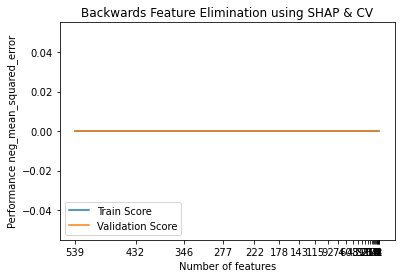

In [41]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=model, step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(X_XGB, np.log1p(y))

# Make plots
performance_plot = shap_elimination.plot()

In [42]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,539,"[12_temp_para65, 13_time_para30, 13_time_para4...","[18_gas_para33, 06_time_para34, 13_efem_para25...",-0.0,0.0,-0.0,0.0
2,432,"[12_temp_para65, 20_power_para57, 06_power_par...","[06_tmp_para31, 13_time_para67, module_name_45...",-0.0,0.0,-0.0,0.0
3,346,"[12_temp_para65, 06_power_para57, 13_time_para...","[module_name_eq_9, module_name_4, 04_temp_para...",-0.0,0.0,-0.0,0.0
4,277,"[12_temp_para65, 13_time_para43, 20_time_para3...","[04_position_para72, 20_time_para41, 04_time_p...",-0.0,0.0,-0.0,0.0
5,222,"[12_temp_para65, 13_time_para43, 13_time_para7...","[module_name_30, 17_efem_para25, 20_temp_para5...",-0.0,0.0,-0.0,0.0
6,178,"[12_temp_para65, 13_gas_para73, 12_temp_para12...","[13_time_para43, 13_gas_para73, 06_gas_para6, ...",-0.0,0.0,-0.0,0.0
7,143,"[12_temp_para65, 04_temp_para65, 13_time_para2...","[module_name_7, 20_time_para29, 12_pressure_pa...",-0.0,0.0,-0.0,0.0
8,115,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[04_time_para9, 20_time_para7, 17_fr_para61, 2...",-0.0,0.0,-0.0,0.0
9,92,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[13_gas_para21, 04_tmp_para31, 17_power_para76...",-0.0,0.0,-0.0,0.0
10,74,"[12_temp_para65, 13_time_para29, 18_fr_para35,...","[12_temp_para32, 06_temp_para65, 13_gas_para52...",-0.0,0.0,-0.0,0.0


In [62]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=69)

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [63]:
final_features_set

['18_hv_para56',
 '13_efem_para78',
 'module_name_31',
 '06_time_para34',
 '06_gas_para6',
 '06_temp_para66',
 '13_time_para83',
 '04_temp_para38',
 '13_temp_para60',
 '18_time_para37',
 '04_efem_para78',
 '18_hv_para3',
 '20_efem_para78',
 '20_temp_para18',
 '18_time_para75',
 '20_gas_para33',
 'module_name_11',
 '04_power_para76',
 '06_temp_para53',
 '13_tmp_para31',
 '13_temp_para12',
 'module_name_8',
 '06_temp_para87',
 '04_time_para83',
 '06_gas_para73',
 '13_gas_para52',
 '18_fr_para61',
 '06_he_para22',
 '06_temp_para54',
 '18_temp_para18',
 '20_time_para44',
 '04_gas_para52',
 '20_temp_para11',
 '20_temp_para87',
 '20_gas_para59',
 '20_temp_para65',
 '06_time_para41',
 '04_time_para77',
 '06_power_para76',
 '20_temp_para53',
 '18_time_para16',
 'module_name_27',
 '04_efem_para2',
 '18_gas_para33',
 'module_name_39',
 'module_name_7',
 '20_temp_para17',
 '18_temp_para60',
 '20_time_para30',
 '13_power_para76',
 '18_time_para64',
 'module_name_eq_1',
 '13_temp_para86',
 '04_time

In [64]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def objective(trial):
    params_xgb = {
        'optimizer':trial.suggest_categorical('optimizer',['gbtree','gblinear','dart']),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2022]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1 ),
    }
    
    # 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다. 
    X_train, X_valid, y_train, y_valid = train_test_split(X_XGB[final_features_set], np.log1p(y), test_size=0.1, random_state=71)

    model = xgb.XGBRegressor(**params_xgb)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=35,
        verbose=False
    )

    xgb_pred = model.predict(X_valid)
    rmse_val = RMSE(y_valid, xgb_pred)
    
    return rmse_val

In [65]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="xgb_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-04 14:21:16,254] A new study created in memory with name: xgb_parameter_opt


[14:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:16,707] Trial 0 finished with value: 0.0058 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 60, 'lambda_l2': 15, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 285, 'feature_fraction': 0.9}. Best is trial 0 with value: 0.0058.


[14:21:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:17,725] Trial 1 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 70, 'lambda_l2': 45, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 23, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:18,215] Trial 2 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 85, 'lambda_l2': 70, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 153, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:18,807] Trial 3 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 20, 'lambda_l2': 5, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 110, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:19,243] Trial 4 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 30, 'lambda_l2': 25, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 68, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:20,388] Trial 5 finished with value: 0.006 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 95, 'lambda_l2': 10, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 2, 'feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.0057.


[14:21:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:21,268] Trial 6 finished with value: 0.0057 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 20, 'lambda_l2': 70, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 112, 'feature_fraction': 0.2}. Best is trial 1 with value: 0.0057.


[14:21:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:22,313] Trial 7 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 100, 'lambda_l2': 85, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 211, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.0057.


[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:22,746] Trial 8 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 5, 'lambda_l2': 60, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'random_state': 2022, 'min_child_weight': 289, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.0057.


[14:21:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:23,432] Trial 9 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 15, 'lambda_l2': 25, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 113, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:24,654] Trial 10 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 65, 'lambda_l2': 40, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 4, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.0057.


[14:21:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:25,163] Trial 11 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 95, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 196, 'feature_fraction': 0.5}. Best is trial 1 with value: 0.0057.


[14:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:25,650] Trial 12 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 45, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 2022, 'min_child_weight': 180, 'feature_fraction': 0.7}. Best is trial 1 with value: 0.0057.


[14:21:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:26,410] Trial 13 finished with value: 0.0057 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 50, 'lambda_l2': 70, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2022, 'min_child_weight': 55, 'feature_fraction': 0.9}. Best is trial 1 with value: 0.0057.


[14:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:26,944] Trial 14 finished with value: 0.0058 and parameters: {'optimizer': 'gbtree', 'lambda_l1': 80, 'lambda_l2': 60, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 7, 'random_state': 2022, 'min_child_weight': 237, 'feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.0057.


[14:21:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:27,934] Trial 15 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 50, 'lambda_l2': 80, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 150, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:28,789] Trial 16 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 40, 'lambda_l2': 100, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 61, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:29,645] Trial 17 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 45, 'lambda_l2': 100, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2022, 'min_child_weight': 76, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:30,461] Trial 18 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 65, 'lambda_l2': 35, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 5, 'random_state': 2022, 'min_child_weight': 245, 'feature_fraction': 0.4}. Best is trial 15 with value: 0.0056.


[14:21:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:31,173] Trial 19 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 20, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 128, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:31,908] Trial 20 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 151, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:32,773] Trial 21 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 35, 'lambda_l2': 30, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 32, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:33,624] Trial 22 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 35, 'lambda_l2': 25, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 133, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:34,487] Trial 23 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 20, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 127, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:35,197] Trial 24 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 15, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 177, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:35,748] Trial 25 finished with value: 0.0058 and parameters: {'optimizer': 'dart', 'lambda_l1': 55, 'lambda_l2': 55, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 2022, 'min_child_weight': 136, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


[14:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:36,452] Trial 26 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 0, 'lambda_l2': 85, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 99, 'feature_fraction': 0.6000000000000001}. Best is trial 15 with value: 0.0056.


[14:21:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:37,169] Trial 27 finished with value: 0.0057 and parameters: {'optimizer': 'dart', 'lambda_l1': 25, 'lambda_l2': 20, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 89, 'feature_fraction': 0.5}. Best is trial 15 with value: 0.0056.


[14:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:37,912] Trial 28 finished with value: 0.0056 and parameters: {'optimizer': 'dart', 'lambda_l1': 10, 'lambda_l2': 0, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 134, 'feature_fraction': 0.7}. Best is trial 15 with value: 0.0056.


[14:21:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "feature_fraction", "lambda_l1", "lambda_l2", "optimizer" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2022-07-04 14:21:39,048] Trial 29 finished with value: 0.0057 and parameters: {'optimizer': 'gblinear', 'lambda_l1': 35, 'lambda_l2': 0, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 2022, 'min_child_weight': 162, 'feature_fraction': 0.8}. Best is trial 15 with value: 0.0056.


Best Score: 0.0056
Best trial: {'optimizer': 'dart', 'lambda_l1': 50, 'lambda_l2': 80, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 15, 'random_state': 2022, 'min_child_weight': 150, 'feature_fraction': 0.8}


# 예측 결과 제출

In [249]:
df_predict.head()

,module_name,key_val,04_temp_para86,04_time_para8,13_time_para90,17_position_para72,17_temp_para66,20_temp_para86,17_gas_para33,06_time_para67,...,18_end_time,20_end_time,module_name_eq,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,0,LOT380_17,22.056250,37.800000,37.85000,16.366667,90.01755,25.906235,0.0,2965.1000,...,2021-10-28 08:39:22,2021-10-28 08:46:13,0,1837.0,123.0,795.0,16.0,476.0,16.0,411.0
1,0,LOT122_18,22.041930,63.233330,63.28333,16.314820,90.01404,25.912940,0.0,2990.5330,...,2021-10-29 12:12:57,2021-10-29 12:19:48,0,1838.0,122.0,796.0,16.0,477.0,16.0,411.0
2,0,LOT313_18,22.018750,73.650000,73.70000,16.392593,89.99298,25.919651,0.0,3000.9500,...,2021-10-29 23:29:36,2021-10-29 23:36:27,0,1838.0,122.0,796.0,16.0,477.0,16.0,411.0
3,0,LOT459_12,22.072727,98.083336,98.13333,16.396296,90.01579,25.951250,0.0,3025.3833,...,2021-10-31 04:03:35,2021-10-31 04:10:25,0,1843.0,123.0,801.0,16.0,477.0,16.0,410.0
4,0,LOT459_18,22.012903,99.250000,99.30000,16.394444,90.00702,25.963840,0.0,3026.5500,...,2021-10-31 05:19:01,2021-10-31 05:25:52,0,1841.0,121.0,801.0,16.0,476.0,16.0,411.0


In [55]:
pred_X = pd.get_dummies(df_predict[COLS])

In [33]:
predict['msure_val'] = np.exp(cat.predict(df_predict_final[COLS]))
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1261.069099
1,LOT122_18,1263.882140
2,LOT313_18,1265.600156
3,LOT459_12,1264.095864
4,LOT459_18,1265.368856


In [34]:
# 예측값에 결측치가 포함되어 있는지 확인합니다.
df_submission.isnull().sum()

key_val      0
msure_val    0
dtype: int64

In [58]:
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 262
No. of Submission DataSet : 262


In [35]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_12.csv')

In [ ]:
cv 하는거 참조
https://dacon.io/en/competitions/official/235877/codeshare/4710

In [ ]:
step4 : ['gas_para21','gas_para36','gas_para59','gas_para6','he_para22','he_para88','position_para72','power_para76','pressure_para91','temp_para12','temp_para18','temp_para20','temp_para38','temp_para54','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para89','time_para9','time_para90','tmp_para31']
step6 : ['epd_para4','epd_para63','esc_para94','gas_para23','gas_para26','gas_para36','gas_para6','he_para22','he_para88','position_para72','power_para49','power_para57','power_para76','temp_para12','temp_para18','temp_para20','temp_para38','temp_para54','temp_para58','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step12 : ['gas_para21','gas_para36','gas_para6','gas_para73','he_para22','he_para88','hv_para45','hv_para47','hv_para56','position_para72','power_para14','temp_para12','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step13 : ['gas_para21','gas_para36','gas_para59','gas_para6','gas_para73','he_para22','he_para88','hv_para45','hv_para47','hv_para56','position_para72','power_para14','power_para76','power_para82','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step17 : ['fr_para28','fr_para69','gas_para21','gas_para36','gas_para59','gas_para6','gas_para73','he_para22','he_para88','position_para72','power_para14','power_para76','power_para82','temp_para12','temp_para18','temp_para20','temp_para24','temp_para38','temp_para60','temp_para65','temp_para86','time_para16','time_para29','time_para30','time_para34','time_para37','time_para41','time_para42','time_para43','time_para5','time_para62','time_para64','time_para67','time_para7','time_para75','time_para77','time_para8','time_para81','time_para83','time_para9','time_para90','tmp_para31']
step18 : []

# PYCARET 용

In [67]:
pred['Label']

,17_pressure_para91,12_gas_para26,17_temp_para32,06_gas_para26,04_gas_para26,13_gas_para52,20_gas_para26,13_temp_para32,18_temp_para32,20_gas_para73,...,module_name_eq_3,module_name_eq_4,module_name_eq_5,module_name_eq_6,module_name_eq_7,module_name_eq_8,module_name_eq_9,module_name_eq_10,module_name_eq_11,Label
0,0.102933,1.133793,-1.008070,0.193044,-0.691354,0.526658,0.759050,0.419387,-0.895134,-0.179310,...,0,0,0,0,0,0,0,0,0,1263.050330
1,0.104847,-0.446933,0.174962,-0.188963,-0.027962,-1.929976,0.831439,-0.515447,0.177806,0.380726,...,0,0,0,0,0,0,0,0,0,1262.358214
2,-0.782996,1.246835,-0.163199,0.191364,0.078791,2.061944,1.942678,0.575196,-0.442715,0.068077,...,0,0,0,0,0,0,0,0,0,1261.775813
3,0.102933,-1.915237,0.174673,-0.570130,0.178150,2.983224,0.494893,0.107749,-1.218331,0.489824,...,0,0,0,0,0,0,0,0,0,1261.710770
4,0.102933,-0.898791,0.005641,0.384047,-2.019527,0.526658,-0.864375,-0.048060,-0.752965,0.579472,...,0,0,0,0,0,0,0,0,0,1262.698655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.988863,-0.673017,0.681625,0.578199,-0.691354,0.219621,0.704441,-1.294594,0.022651,-1.437574,...,0,0,0,0,0,0,0,0,1,1260.958137
258,-0.784909,-0.446933,-0.501167,0.575050,1.233663,0.526658,-0.068982,-0.203910,-0.287620,0.109544,...,0,0,0,0,0,0,0,0,1,1260.230169
259,1.874792,0.117656,0.850513,-0.570130,0.550861,0.219621,0.482193,0.419387,0.488017,0.257312,...,0,0,0,0,0,0,0,0,1,1260.390879
260,-0.782996,-0.559975,0.512641,-0.760504,-0.306397,0.526658,-0.036978,-0.359699,0.177766,0.439307,...,0,0,0,0,0,0,0,0,1,1260.697004


In [68]:
predict['msure_val'] = pred['Label']
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

,key_val,msure_val
0,LOT380_17,1263.050330
1,LOT122_18,1262.358214
2,LOT313_18,1261.775813
3,LOT459_12,1261.710770
4,LOT459_18,1262.698655


In [69]:
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_8.csv')

In [70]:
df_submission.isnull().sum()
# 예측값의 갯수가 평가용 데이터의 갯수와 동일한지 확인합니다.
assert len(df_submission) == len(predict)
print(f'No. of Predict DataSet : {len(predict)}\nNo. of Submission DataSet : {len(df_submission)}')

No. of Predict DataSet : 262
No. of Submission DataSet : 262


# CV 해보기

In [87]:
train_X, train_y = X_one_hot, pd.Series(np.log1p(y))
print(train_X.shape, train_y.shape)

(611, 240) (611,)


In [88]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=13)
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [89]:
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [90]:
reg = LinearRegression(n_jobs=-1)
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1, n_jobs=-1)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [91]:
models = []
scores = []
for model in [reg, ridge, lasso, Enet, DTree, rf, model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 13it [00:00, 82.26it/s]                                                         
Ridge Cross Validations...: 13it [00:00, 152.91it/s]                                                                   
Lasso Cross Validations...: 13it [00:00, 175.64it/s]                                                                   
ElasticNet Cross Validations...:   0%|                                                          | 0/10 [00:00<?, ?it/s]

1 FOLDS: LinearRegression RMSLE: 0.0187
2 FOLDS: LinearRegression RMSLE: 0.0297
3 FOLDS: LinearRegression RMSLE: 0.0823
4 FOLDS: LinearRegression RMSLE: 0.1555
5 FOLDS: LinearRegression RMSLE: 0.0706
6 FOLDS: LinearRegression RMSLE: 0.0194
7 FOLDS: LinearRegression RMSLE: 0.0169
8 FOLDS: LinearRegression RMSLE: 0.0409
9 FOLDS: LinearRegression RMSLE: 0.0186
10 FOLDS: LinearRegression RMSLE: 0.0156
11 FOLDS: LinearRegression RMSLE: 0.0117
12 FOLDS: LinearRegression RMSLE: 0.0138
13 FOLDS: LinearRegression RMSLE: 0.0248

LinearRegression mean RMSLE: 0.0399
1 FOLDS: Ridge RMSLE: 0.0127
2 FOLDS: Ridge RMSLE: 0.0089
3 FOLDS: Ridge RMSLE: 0.0231
4 FOLDS: Ridge RMSLE: 0.0356
5 FOLDS: Ridge RMSLE: 0.0481
6 FOLDS: Ridge RMSLE: 0.0096
7 FOLDS: Ridge RMSLE: 0.0184
8 FOLDS: Ridge RMSLE: 0.0138
9 FOLDS: Ridge RMSLE: 0.0144
10 FOLDS: Ridge RMSLE: 0.0074
11 FOLDS: Ridge RMSLE: 0.0115
12 FOLDS: Ridge RMSLE: 0.0099
13 FOLDS: Ridge RMSLE: 0.0137

Ridge mean RMSLE: 0.0175
1 FOLDS: Lasso RMSLE: 0.0061
2 F

ElasticNet Cross Validations...: 13it [00:00, 83.85it/s]                                                               
DecisionTreeRegressor Cross Validations...:  90%|███████████████████████████████████    | 9/10 [00:00<00:00, 79.63it/s]

1 FOLDS: ElasticNet RMSLE: 0.0062
2 FOLDS: ElasticNet RMSLE: 0.0080
3 FOLDS: ElasticNet RMSLE: 0.0083
4 FOLDS: ElasticNet RMSLE: 0.0061
5 FOLDS: ElasticNet RMSLE: 0.0052
6 FOLDS: ElasticNet RMSLE: 0.0051
7 FOLDS: ElasticNet RMSLE: 0.0087
8 FOLDS: ElasticNet RMSLE: 0.0077
9 FOLDS: ElasticNet RMSLE: 0.0067
10 FOLDS: ElasticNet RMSLE: 0.0060
11 FOLDS: ElasticNet RMSLE: 0.0060
12 FOLDS: ElasticNet RMSLE: 0.0069
13 FOLDS: ElasticNet RMSLE: 0.0068

ElasticNet mean RMSLE: 0.0067


DecisionTreeRegressor Cross Validations...: 13it [00:00, 56.51it/s]                                                    
RandomForestRegressor Cross Validations...:   0%|                                               | 0/10 [00:00<?, ?it/s]

1 FOLDS: DecisionTreeRegressor RMSLE: 0.0058
2 FOLDS: DecisionTreeRegressor RMSLE: 0.0074
3 FOLDS: DecisionTreeRegressor RMSLE: 0.0081
4 FOLDS: DecisionTreeRegressor RMSLE: 0.0064
5 FOLDS: DecisionTreeRegressor RMSLE: 0.0066
6 FOLDS: DecisionTreeRegressor RMSLE: 0.0054
7 FOLDS: DecisionTreeRegressor RMSLE: 0.0094
8 FOLDS: DecisionTreeRegressor RMSLE: 0.0095
9 FOLDS: DecisionTreeRegressor RMSLE: 0.0068
10 FOLDS: DecisionTreeRegressor RMSLE: 0.0101
11 FOLDS: DecisionTreeRegressor RMSLE: 0.0056
12 FOLDS: DecisionTreeRegressor RMSLE: 0.0082
13 FOLDS: DecisionTreeRegressor RMSLE: 0.0072

DecisionTreeRegressor mean RMSLE: 0.0074


RandomForestRegressor Cross Validations...: 13it [00:10,  1.23it/s]                                                    
XGBRegressor Cross Validations...:   0%|                                                        | 0/10 [00:00<?, ?it/s]

1 FOLDS: RandomForestRegressor RMSLE: 0.0061
2 FOLDS: RandomForestRegressor RMSLE: 0.0078
3 FOLDS: RandomForestRegressor RMSLE: 0.0071
4 FOLDS: RandomForestRegressor RMSLE: 0.0056
5 FOLDS: RandomForestRegressor RMSLE: 0.0055
6 FOLDS: RandomForestRegressor RMSLE: 0.0048
7 FOLDS: RandomForestRegressor RMSLE: 0.0086
8 FOLDS: RandomForestRegressor RMSLE: 0.0075
9 FOLDS: RandomForestRegressor RMSLE: 0.0062
10 FOLDS: RandomForestRegressor RMSLE: 0.0071
11 FOLDS: RandomForestRegressor RMSLE: 0.0053
12 FOLDS: RandomForestRegressor RMSLE: 0.0063
13 FOLDS: RandomForestRegressor RMSLE: 0.0062

RandomForestRegressor mean RMSLE: 0.0065


XGBRegressor Cross Validations...: 13it [00:16,  1.30s/it]                                                             
LGBMRegressor Cross Validations...:  20%|█████████▍                                     | 2/10 [00:00<00:00, 14.39it/s]

1 FOLDS: XGBRegressor RMSLE: 0.0061
2 FOLDS: XGBRegressor RMSLE: 0.0074
3 FOLDS: XGBRegressor RMSLE: 0.0068
4 FOLDS: XGBRegressor RMSLE: 0.0056
5 FOLDS: XGBRegressor RMSLE: 0.0056
6 FOLDS: XGBRegressor RMSLE: 0.0049
7 FOLDS: XGBRegressor RMSLE: 0.0086
8 FOLDS: XGBRegressor RMSLE: 0.0076
9 FOLDS: XGBRegressor RMSLE: 0.0071
10 FOLDS: XGBRegressor RMSLE: 0.0064
11 FOLDS: XGBRegressor RMSLE: 0.0054
12 FOLDS: XGBRegressor RMSLE: 0.0063
13 FOLDS: XGBRegressor RMSLE: 0.0066

XGBRegressor mean RMSLE: 0.0065


LGBMRegressor Cross Validations...: 13it [00:04,  2.95it/s]                                                            

1 FOLDS: LGBMRegressor RMSLE: 0.0082
2 FOLDS: LGBMRegressor RMSLE: 0.0088
3 FOLDS: LGBMRegressor RMSLE: 0.0075
4 FOLDS: LGBMRegressor RMSLE: 0.0057
5 FOLDS: LGBMRegressor RMSLE: 0.0062
6 FOLDS: LGBMRegressor RMSLE: 0.0043
7 FOLDS: LGBMRegressor RMSLE: 0.0084
8 FOLDS: LGBMRegressor RMSLE: 0.0084
9 FOLDS: LGBMRegressor RMSLE: 0.0063
10 FOLDS: LGBMRegressor RMSLE: 0.0081
11 FOLDS: LGBMRegressor RMSLE: 0.0048
12 FOLDS: LGBMRegressor RMSLE: 0.0064
13 FOLDS: LGBMRegressor RMSLE: 0.0058

LGBMRegressor mean RMSLE: 0.0068


In [92]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LinearRegression,0.039881
1,Ridge,0.017466
2,Lasso,0.006485
3,ElasticNet,0.006749
4,DecisionTreeRegressor,0.007422
5,RandomForestRegressor,0.006465
6,XGBRegressor,0.006485
7,LGBMRegressor,0.006830


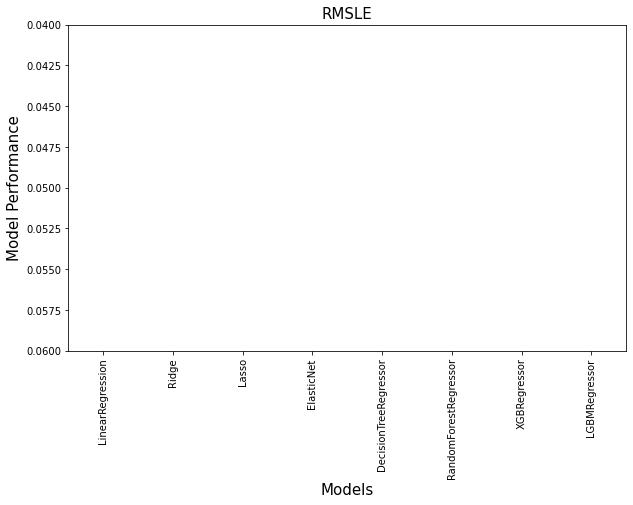

In [94]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.06, 0.04)
plt.title('RMSLE', fontsize=15)
plt.show()